# Probing Non-Quantum Noise with Quantum Squeezing

In [2]:
import numpy as np
from numpy.random import randn, rand
import scipy as sp
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerTuple
import corner
from wand.image import Image as WImage


import os
import sys
from copy import deepcopy
import time
import csv
import glob
import importlib


import emcee
import multiprocessing
import queue
from itertools import count

# import sys
# sys.path.insert(0, './pygwinc/')

import gwinc

from gwinc.noise.quantum import shotrad_debug
import lib

matplotlib.rc('font',**{'family':'serif','serif':['Times'], 'size':16})
matplotlib.rc('text', usetex=True)

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Analysis of Sensing Function #

The sensing function is an optical gain that converts the measured optical power fluctuation in Watt to the change of the length difference between two arms of LIGO, known as differential arm lengths (DARM). The sensing function depends only on the unsqueezed interometer's response to the arm length perturbations, mostly including degradations of the output path and responses of the signal-recycling cavity (SRC, sometimes also called as sideband-extraction cavity, SEC). 

In **conventional SRC response formalism**, the SRC length (SRCL) detuning is related to the optical spring frequency and Q factor of the detuned SRC. They can be found in the calibration report ([05/02 report](https://alog.ligo-la.caltech.edu/aLOG/uploads/64934_20230518151612_L1_calibration_report_20230502T224106Z.pdf) and [05/19 report](https://llocds.ligo-la.caltech.edu/data/wenxuan.jia/L1_calibration_report_20230519T153633Z.pdf)). The derivation can be found in [T1600278](https://dcc.ligo.org/DocDB/0127/T1600278/002/T1600278_v2_detunedDARM.pdf) and [CQG. 36 205006](https://arxiv.org/pdf/1712.09719.pdf). However, the conventional analytical formalism is known to have issues. Instead, numerical simulation like gwinc can handle all parameters that may affect SRC responses. Its sensing function is more accurate than the single-pole approximation.

The calibration sweep measures the sensing function, which includes coupled-cavity pole ($f_{cc}$) and SRC spring information at low frequencies. The $f_{cc}$ is not an accurate description of the sensing function if we have mode-mismatches. Therefore, we infer SRC parameters from sensing functions produced by gwinc.

The sensing function $C$ depends on these paramters:

- Arm power $P_{arm}$
- Readout loss $\Lambda_{RO}$
- Interferometer (IFO) to output mode cleaner (OMC) mode-mismatch $\Upsilon_{OMC}$
- IFO to OMC mode-mismatch phase $\Upsilon_{OMC}$ phase
- SRC loss $\Lambda_{SR}$
- Arm cavity to SRC mode-mismatch $\Upsilon_{SR}$
- Arm to SRC mode-mismatch phase $\Upsilon_{SR}$ phase
- SRC Gouy phase $\psi_{SR}$
- SRC detuning $\Delta \phi_{SR}$

## Parametric study ##

We perform a parametric study to understand how each of the gwinc parameters affect the sensing function. We first find canonical set of parameters that closely represents the truth, and then perturb each dimension from that point. The change of the modeled sensing function is plotted with respect to each dimension that is perturbed. 

There are two scenarios with the arm to SRC mismatch $\Upsilon_{SR}$, controlled by the parameter is_OPD. When is_OPD is true, the thermal lensing is more dominant than quadratic mode-mismatch, creating the optical path distortion and thus the name of the parameter. We analyze both case separately:

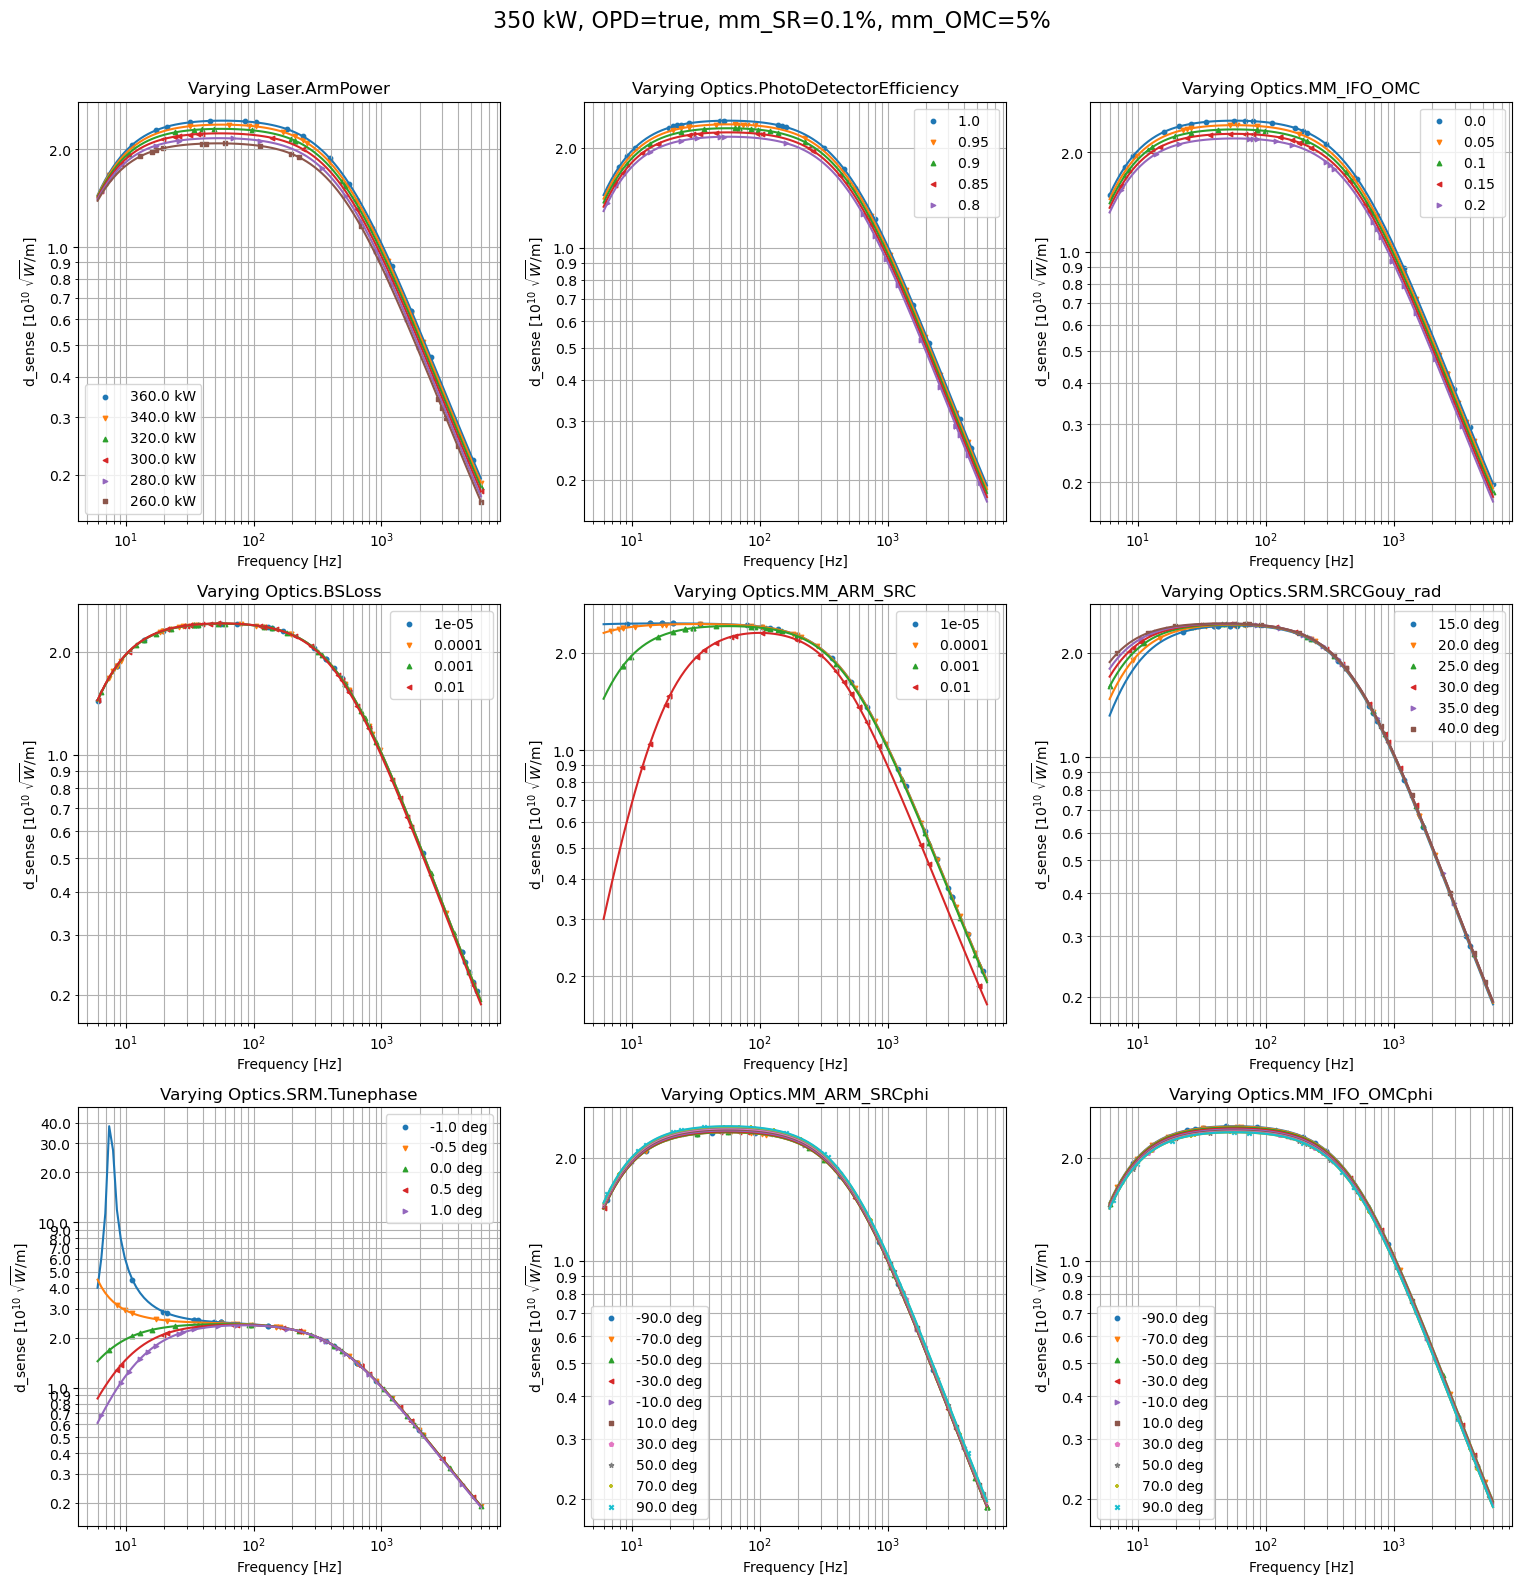

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plotUnsqzC(param, yaxis, title):
    paramName = param['Name']
    paramList = param['List']
    paramLabel = param['Label']
    paramUnit = param['Unit']
    
    yscale = yaxis['Scale']
    yscalenum = yaxis['ScaleNum']
    ylabel0 = yaxis['Label0']
    
    title0 = 'Varying ' + paramName + title
    filename = './fig/C/C_' + paramName + '.pdf';
    
    freq = np.geomspace(6, 6000, 100);

    ifo = load_budget('Aplus').ifo

    ifo.Optics.is_OPD = True # default is False

    ifo.Optics.ITM.Transmittance = 0.0148
    ifo.Optics.ETM.Transmittance = 5e-6

    if True:
        ifo.Laser.ArmPower = 350e3
        del ifo.Laser.Power
    else:
        ifo.Laser.Power = 63.73*0.97
        ifo.Optics.Loss = loss_arm/2;

    ifo.Optics.Quadrature.dc = np.pi / 180 * (90) # theta_LO


    ifo.Squeezer.AmplitudedB = 0 # z_eff_dB

    ifo.Optics.BSLoss = 500e-6
    ifo.Optics.SRM.SRCGouy_rad = 19 *np.pi/180
    ifo.Optics.SRM.Tunephase = 0 *np.pi/180 # SRCL_detuning

    ifo.Optics.MM_ARM_SRC = 0.001
    ifo.Optics.MM_ARM_SRCphi = 0 *np.pi/180


    ifo.Optics.MM_IFO_OMC = 0.05
    ifo.Optics.MM_IFO_OMCphi = 0 *np.pi/180

    ifo.Optics.PhotoDetectorEfficiency = 1- 0


    Slist = list();
    for j in range(len(paramList)):
        ifo[paramName] = paramList[j]
        sr = shotrad_debug(freq, ifo)
        C = sr.d_sense;
        Slist.append(C);


    markerType = ['o', 'v','^', '<', '>', 's', 'p', '*', '+', 'x', 'd']

    density = 1 # scaling 
    num = np.int64(len(freq)/len(Slist)*density)

    for j in range(len(paramList)):
        data = abs(Slist[j])
        plt.loglog(freq, yscalenum*data, linewidth=1.5);
        id = np.int64(np.ceil(np.random.rand(num)*len(data))) - 1
        plt.scatter(freq[id], yscalenum*data[id], marker=markerType[j%len(markerType)],
                    s=10, label=str(paramLabel[j])+' '+paramUnit)


    plt.xlabel('Frequency [Hz]'); plt.ylabel(ylabel0); 
    # plt.xscale("log")
    plt.yscale(yscale)
    ax = plt.gca()
    ax.yaxis.set_minor_formatter('{x:.1f}')
    ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    plt.legend()
    plt.title(title0)
    # plt.savefig(filename)
    # plt.show()




yaxis = {
    'Scale': 'log',
    'ScaleNum': 1e-10,
    'Label0': 'd_sense [$10^{10}$ $\sqrt{W}$/m]'
}

title = '350 kW, OPD=true, mm_SR=0.1%, mm_OMC=5%'
filename = 'is_OPD_mm_SR_.001_mm_OMC_.05'

title0 = ''

plt.figure(1)

# plt.subplot(331)
# param = {
#     'Name': 'Optics.Quadrature.dc',
#     'List': np.pi / 180 * (90 + np.arange(-20,20 +5,5)),
#     'Label': np.arange(-20,20 +5,5),
#     'Unit': 'deg'
# }
# plotUnsqzC(param, yaxis, title0)

plt.subplot(331)
paramList = np.arange(360, 260-20, -20)*1e3
param = {
    'Name': 'Laser.ArmPower',
    'List': paramList,
    'Label': paramList/1e3,
    'Unit': 'kW'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(334)
paramList = np.logspace(-5, -2, 4)
param = {
    'Name': 'Optics.BSLoss',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(337)
paramList = np.pi/180*np.linspace(-1,1,5).round(2)
param = {
    'Name': 'Optics.SRM.Tunephase',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(335)
paramList = np.logspace(-5, -2, 4)
param = {
    'Name': 'Optics.MM_ARM_SRC',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(338)
paramList = np.pi/180*np.linspace(-90, 90, 10)
param = {
    'Name': 'Optics.MM_ARM_SRCphi',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(333)
paramList = np.linspace(0, 0.2, 5).round(3)
param = {
    'Name': 'Optics.MM_IFO_OMC',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(339)
paramList = np.pi/180*np.linspace(-90, 90, 10)
param = {
    'Name': 'Optics.MM_IFO_OMCphi',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(332)
paramList = 1 - np.linspace(0, 0.2, 5).round(3)
param = {
    'Name': 'Optics.PhotoDetectorEfficiency',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(336)
paramList = np.pi/180*np.arange(15,45,5)
param = {
    'Name': 'Optics.SRM.SRCGouy_rad',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
fig.suptitle(title, y=0.93, fontsize=16)
plt.savefig('./fig/C/C_' + filename + '.pdf')
plt.show()

# paramName = 'L_SR_rms';
# paramList = logspace(-12, -6, 7);
# paramName = 'T_SR';
# paramList = 0.31:0.005:0.34;
# paramName = 'z_eff_dB';
# paramList = 10:2:18;
# paramName = 'loss_INJ_unknown';
# paramList = 0.05:0.02:0.12;
# paramName = 'phaseNoise';
# paramList = (100:100:1000)*1e-3;
# paramName = 'mm_SQZ2OMC';
# paramList = 0:0.025:0.20; 



These plots show how the sensing function from gwinc is affected by ifo parameters. The title shows the canonical parameter set where we perturb from. For each subplot, the title says the perturbed parameter. The various values of such parameters are labeled in the legend. The sensing function is therefore very sensitive to $\Upsilon_{SR}$. 

The top row represents degeneracy between arm power and readout loss/mode-mismatches. With only 0.1% of $\Upsilon_{SR}$ and 5% of $\Upsilon_{OMC}$, $\Upsilon_{OMC}$ is quite degenerate with readout loss, and both of them affect the sensing function in the similar way as arm power. Note that it is with small $\Upsilon_{SR}$ .

The center row represents loss/mismatches in SRC. The simple SRC loss changes the coupled cavity pole by a tiny bit, as the high frequency of $C$ changes but not low frequency. $\Upsilon_{SR}$ don't change the cavity pole by much, but they affect the SRC spring heavily due to the extra mismatch phasing. At low $\Upsilon_{SR}$, it affects $C$ like SRCL detuning. When it's large, it also reduces high frequency optical gain. 

The SRC Gouy phase is kind of a hidden parameter that can change over thermalizing. Higher Gouy phase actually damps the spring by changing the mismatch phasing that reduces the misroation when coherently summed with 00 modes. 

The bottom row represents other phasing due to cavity detuning and mismatches. The SRCL detuning affects the spring heavily as expected. Note that it could counteract the effect due to $\Upsilon_{SR}$ so they form a degenerate pair. The other mismatch phasings contribute relatively less than other phasings. Given the low-frequency shape of the measured Pcal sweep, the $\Upsilon_{SR}$ couldn't be too high and therefore the mismatch phasing don't matter much. They would definitely matter with squeezing. 

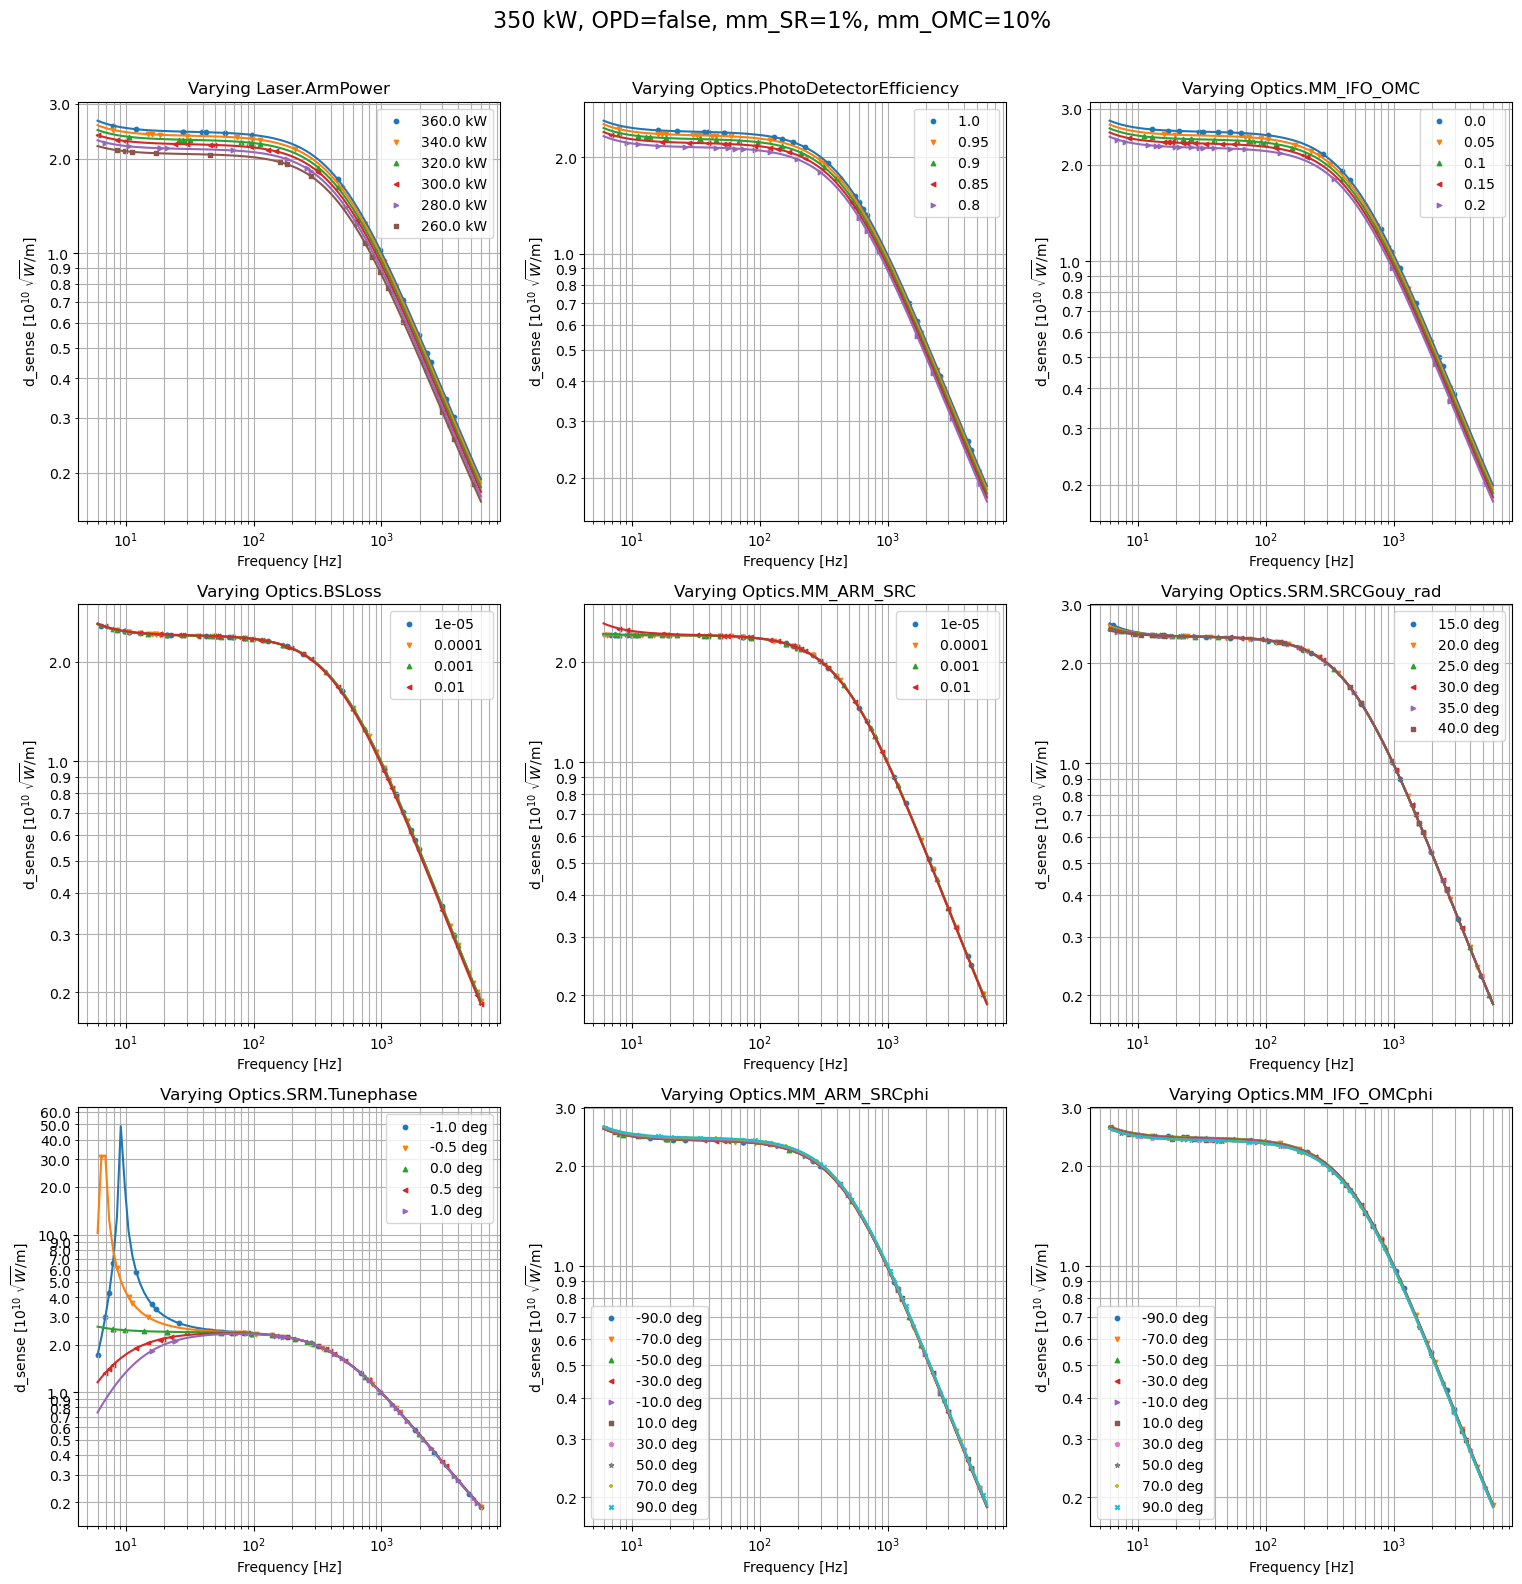

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plotUnsqzC(param, yaxis, title):
    paramName = param['Name']
    paramList = param['List']
    paramLabel = param['Label']
    paramUnit = param['Unit']
    
    yscale = yaxis['Scale']
    yscalenum = yaxis['ScaleNum']
    ylabel0 = yaxis['Label0']
    
    title0 = 'Varying ' + paramName + title
    filename = './fig/C/C_' + paramName + '.pdf';
    
    freq = np.geomspace(6, 6000, 100);

    ifo = load_budget('Aplus').ifo

    ifo.Optics.is_OPD = False # default is False

    ifo.Optics.ITM.Transmittance = 0.0148
    ifo.Optics.ETM.Transmittance = 5e-6

    if True:
        ifo.Laser.ArmPower = 350e3
        del ifo.Laser.Power
    else:
        ifo.Laser.Power = 63.73*0.97
        ifo.Optics.Loss = loss_arm/2;

    ifo.Optics.Quadrature.dc = np.pi / 180 * (90) # theta_LO


    ifo.Squeezer.AmplitudedB = 0 # z_eff_dB

    ifo.Optics.BSLoss = 500e-6
    ifo.Optics.SRM.SRCGouy_rad = 19 *np.pi/180
    ifo.Optics.SRM.Tunephase = 0 *np.pi/180 # SRCL_detuning

    ifo.Optics.MM_ARM_SRC = 0.01
    ifo.Optics.MM_ARM_SRCphi = 0 *np.pi/180


    ifo.Optics.MM_IFO_OMC = 0.1
    ifo.Optics.MM_IFO_OMCphi = 0 *np.pi/180

    ifo.Optics.PhotoDetectorEfficiency = 1- 0


    Slist = list();
    for j in range(len(paramList)):
        ifo[paramName] = paramList[j]
        sr = shotrad_debug(freq, ifo)
        C = sr.d_sense;
        Slist.append(C);


    markerType = ['o', 'v','^', '<', '>', 's', 'p', '*', '+', 'x', 'd']

    density = 1 # scaling 
    num = np.int64(len(freq)/len(Slist)*density)

    for j in range(len(paramList)):
        data = abs(Slist[j])
        plt.loglog(freq, yscalenum*data, linewidth=1.5);
        id = np.int64(np.ceil(np.random.rand(num)*len(data))) - 1
        plt.scatter(freq[id], yscalenum*data[id], marker=markerType[j%len(markerType)],
                    s=10, label=str(paramLabel[j])+' '+paramUnit)


    plt.xlabel('Frequency [Hz]'); plt.ylabel(ylabel0); 
    # plt.xscale("log")
    plt.yscale(yscale)
    ax = plt.gca()
    ax.yaxis.set_minor_formatter('{x:.1f}')
    ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    plt.legend()
    plt.title(title0)
    # plt.savefig(filename)
    # plt.show()




yaxis = {
    'Scale': 'log',
    'ScaleNum': 1e-10,
    'Label0': 'd_sense [$10^{10}$ $\sqrt{W}$/m]'
}

title = '350 kW, OPD=false, mm_SR=1%, mm_OMC=10%'
filename = 'mm_SR_.01_mm_OMC_.1'

title0 = ''

plt.figure(1)

# plt.subplot(331)
# param = {
#     'Name': 'Optics.Quadrature.dc',
#     'List': np.pi / 180 * (90 + np.arange(-20,20 +5,5)),
#     'Label': np.arange(-20,20 +5,5),
#     'Unit': 'deg'
# }
# plotUnsqzC(param, yaxis, title0)

plt.subplot(331)
paramList = np.arange(360, 260-20, -20)*1e3
param = {
    'Name': 'Laser.ArmPower',
    'List': paramList,
    'Label': paramList/1e3,
    'Unit': 'kW'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(334)
paramList = np.logspace(-5, -2, 4)
param = {
    'Name': 'Optics.BSLoss',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(337)
paramList = np.pi/180*np.linspace(-1,1,5).round(2)
param = {
    'Name': 'Optics.SRM.Tunephase',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(335)
paramList = np.logspace(-5, -2, 4)
param = {
    'Name': 'Optics.MM_ARM_SRC',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(338)
paramList = np.pi/180*np.linspace(-90, 90, 10)
param = {
    'Name': 'Optics.MM_ARM_SRCphi',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(333)
paramList = np.linspace(0, 0.2, 5).round(3)
param = {
    'Name': 'Optics.MM_IFO_OMC',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(339)
paramList = np.pi/180*np.linspace(-90, 90, 10)
param = {
    'Name': 'Optics.MM_IFO_OMCphi',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(332)
paramList = 1 - np.linspace(0, 0.2, 5).round(3)
param = {
    'Name': 'Optics.PhotoDetectorEfficiency',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(336)
paramList = np.pi/180*np.arange(15,45,5)
param = {
    'Name': 'Optics.SRM.SRCGouy_rad',
    'List': paramList,
    'Label': paramList/np.pi*180,
    'Unit': 'deg'
}
plotUnsqzC(param, yaxis, title0)

fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
fig.suptitle(title, y=0.93, fontsize=16)
plt.savefig('./fig/C/C_' + filename + '.pdf')
plt.show()

This is the case where is_OPD is false so the thermal lensing is less dominant than quadratic mode-mismatch. The sensing function is not super sensitive to $\Upsilon_{SR}$. We need at least 1% of arm to SRC mismatch to see any effect. 

Without thermal lensing, $\Upsilon_{SR}$ affects the SRC spring in the opposite way, making it more pro-spring. Everything else is pretty much the same as the OPD=true case. The mismatch phasings are not significant here.

## MCMC on Pcal sweep ##

The Pcal sweep data is measured in DARM ERR cts/m. To get W/m, we go back from DARM_ERR to the OMC-DCPD_SUM which has a fairly flat response of 23.974 dB, to where photodiode counts are expressed in mAmps. The filter bank, eg OMC- DCPD_A, includes an unused A2mW bank which comes from the specs of the photodiode (flat gain of 1403). Therefore, the calibration factor is 10**(24/20)/1000*1403/1000.

The diaggui plot is here. The calibration factor is 10**(24/20)/1000*1403/1000. This transfer function is not measured with actuation sweep so the high frequency part is not accurate. 

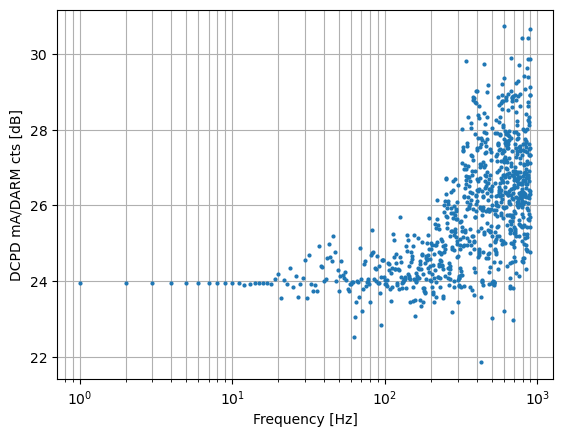

In [493]:
freq, darm, dcpd = np.loadtxt('./data/calibration/DARM2DCPD.txt', unpack=True)

db = 20*np.log10(dcpd/darm)
plt.semilogx(freq, db, marker='o', markersize=2, linewidth=0)
# plt.loglog(freq, dcpd/darm)
plt.xlabel('Frequency [Hz]'); plt.ylabel('DCPD mA/DARM cts [dB]')
plt.grid(which='both')
plt.show()

The sensing function from gwinc (d_sense) is in the unit of $\sqrt{\text{W}}/\text{m}$. To convert it to ${\text{W}}/\text{m}$, we need to multiply it with the sqrt of the LO power on DCPD. We manually fit the pcal data first with both OPD scenarios. 

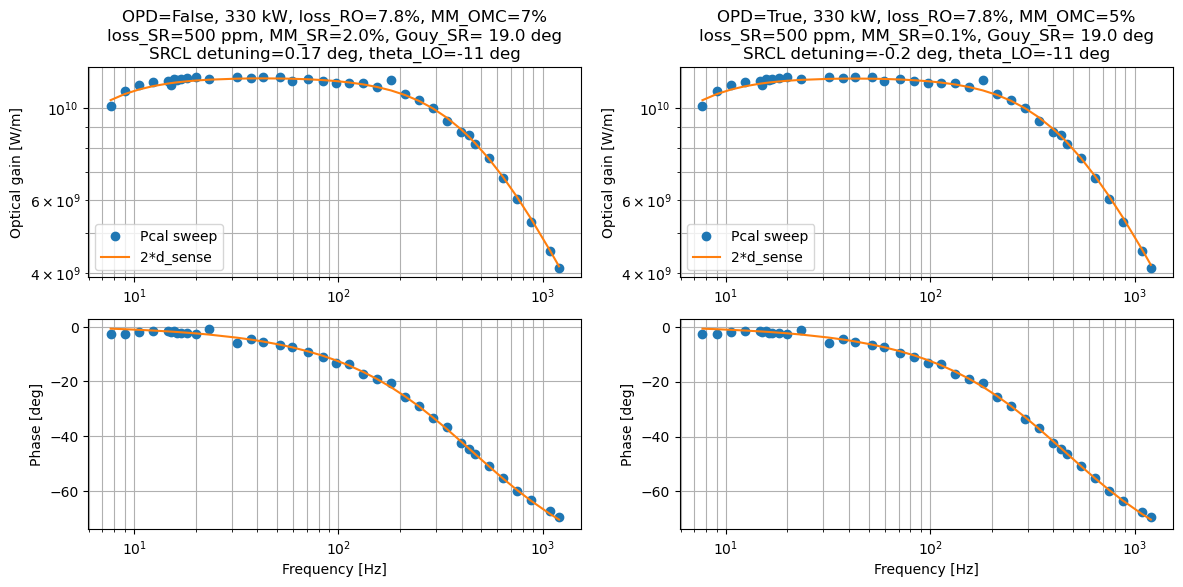

In [494]:
import matplotlib.pyplot as plt
import numpy as np
from gwinc import load_budget
from gwinc.noise.quantum import shotrad_debug
import lib
from copy import deepcopy

d = np.loadtxt('./data/calibration/0502_sensing_response_freq_real_imag_uncert.txt')
freq = d[:,0]
real = d[:,1]
imag = d[:,2]
relerr = d[:,3]

# og_mag = np.sqrt(real**2 + imag**2)*10**(24/20) # mA/m
og_mag = np.sqrt(real**2 + imag**2)*10**(24/20)*1403/1000/1000 # W/m
og_phase = np.angle(real + 1j*imag)*180/np.pi

ifo = load_budget('Aplus').ifo
ifo.Optics.is_OPD = False # default is False
ifo.Optics.ITM.Transmittance = 0.0148
ifo.Optics.ETM.Transmittance = 5e-6
ifo.Laser.ArmPower = 330e3
del ifo.Laser.Power
ifo.Optics.Quadrature.dc = np.pi / 180 * (90-11) # theta_LO
ifo.Squeezer.AmplitudedB = 0 # z_eff_dB
ifo.Optics.BSLoss = 500e-6
ifo.Optics.SRM.SRCGouy_rad = 19 *np.pi/180
ifo.Optics.SRM.Tunephase = 0.17 *np.pi/180 # SRCL_detuning
ifo.Optics.MM_ARM_SRC = 0.02
ifo.Optics.MM_ARM_SRCphi = 0 *np.pi/180
ifo.Optics.MM_IFO_OMC = 0.07
ifo.Optics.MM_IFO_OMCphi = 0 *np.pi/180
ifo.Optics.PhotoDetectorEfficiency = 1 - (0.025 + 0.01 + 800e-6 + 0.015 + 0.007 + 0.02)



sr = shotrad_debug(freq, ifo)
C = sr.d_sense


plt.figure(1)
plt.subplot(221)
plt.loglog(freq, og_mag, marker='o', linewidth=0, label='Pcal sweep')
plt.loglog(freq, abs(C)*np.sqrt(50*1403/1000/1000)*2, label='2*d_sense')
plt.legend()
plt.ylabel('Optical gain [W/m]')
plt.grid(which='both')
plt.title('OPD=' + str(ifo.Optics.is_OPD) + ', ' + str(round(ifo.Laser.ArmPower/1e3)) + ' kW, loss_RO=' + str(round((1-ifo.Optics.PhotoDetectorEfficiency)*100,1)) + 
         '%, MM_OMC=' + str(round(ifo.Optics.MM_IFO_OMC*100)) + '%\nloss_SR=' + str(round(ifo.Optics.BSLoss*1e6)) + ' ppm, ' + 
         'MM_SR=' + str(round(ifo.Optics.MM_ARM_SRC*100,2)) + '%, ' + 'Gouy_SR= ' + str(ifo.Optics.SRM.SRCGouy_rad*180/np.pi) + ' deg\n' +
         'SRCL detuning=' + str(round(ifo.Optics.SRM.Tunephase*180/np.pi, 2)) + ' deg, theta_LO=-11 deg')

plt.subplot(223)
plt.semilogx(freq, og_phase, marker='o', linewidth=0)
plt.semilogx(freq, np.angle(C)*180/np.pi)
plt.ylabel('Phase [deg]'); plt.xlabel('Frequency [Hz]')
# plt.xscale("log")
# plt.yscale("log")
plt.grid(which='both')



ifo.Optics.is_OPD = True # default is False
ifo.Optics.SRM.Tunephase = -0.2 *np.pi/180 # SRCL_detuning
ifo.Optics.MM_ARM_SRC = 0.001
ifo.Optics.MM_IFO_OMC = 0.05


sr = shotrad_debug(freq, ifo)
C = sr.d_sense


plt.subplot(222)
plt.loglog(freq, og_mag, marker='o', linewidth=0, label='Pcal sweep')
plt.loglog(freq, abs(C)*np.sqrt(50*1403/1000/1000)*2, label='2*d_sense')
plt.legend()
plt.ylabel('Optical gain [W/m]')
plt.grid(which='both')
plt.title('OPD=' + str(ifo.Optics.is_OPD) + ', ' + str(round(ifo.Laser.ArmPower/1e3)) + ' kW, loss_RO=' + str(round((1-ifo.Optics.PhotoDetectorEfficiency)*100,1)) + 
         '%, MM_OMC=' + str(round(ifo.Optics.MM_IFO_OMC*100)) + '%\nloss_SR=' + str(round(ifo.Optics.BSLoss*1e6)) + ' ppm, ' + 
         'MM_SR=' + str(round(ifo.Optics.MM_ARM_SRC*100,2)) + '%, ' + 'Gouy_SR= ' + str(ifo.Optics.SRM.SRCGouy_rad*180/np.pi) + ' deg\n' +
         'SRCL detuning=' + str(round(ifo.Optics.SRM.Tunephase*180/np.pi, 2)) + ' deg, theta_LO=-11 deg')

plt.subplot(224)
plt.semilogx(freq, og_phase, marker='o', linewidth=0)
plt.semilogx(freq, np.angle(C)*180/np.pi)
plt.ylabel('Phase [deg]'); plt.xlabel('Frequency [Hz]')
# plt.xscale("log")
# plt.yscale("log")
plt.grid(which='both')

fig = plt.gcf()
fig.set_size_inches(14, 6)

plt.savefig('./fig/C/Pcal_fit_C.pdf')
plt.show()

There's a factor of 2 difference between the gwinc model and measured optical gain. We've compared the optical gain with another simulation tool [o_O](https://git.ligo.org/wenxuan.jia/o_O) and they match relatively well. We will still fit the offset difference anyway. 

Knowing one set of parameters that's close to truth, we can perform a Monte-Carlo-Markov-Chain (MCMC) method to infer those parameters that could significantly affect the sensing function. We have 5 degrees of freedom in the MCMC run: scale factor, SRC loss, SRCL offset, ARM2SRC mismatch, and IFO2OMC mismatch. The arm power and readout loss are absorbed in the scale factor. The initial walkers are distributed perturbatively around the optimal point found manually. The MCMC result is shown in the corner plot. 


In [478]:
import emcee
import numpy as np
from gwinc.noise.quantum import shotrad_debug
from gwinc import load_budget
from numpy.random import randn, rand
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)

def model(theta, freq, ifo, key):
    for j in range(len(key)):
        if key[j] == 'scale':
            scale = theta[j]
        elif j == 2:
            ifo[key[j]] = theta[j]
        else:
            ifo[key[j]] = db2mag(theta[j])
    
    sr = shotrad_debug(freq, ifo)
    C = sr.d_sense
    C = scale*C*np.sqrt(50*1403/1000/1000) # W/m
    return C


def logFlatPrior(theta, bound):
    prior = 0
    for j in range(len(theta)):
        if theta[j] < bound[j][0] or theta[j] > bound[j][1]:
            #print(str(theta[j]) + " out of " + str(bound[j]))
            prior = -np.inf
    return prior


def logLike(theta, freq, ifo, key, data, relerr):
    mdl = model(theta, freq, ifo, key)
    result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)
    # result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2)
    if np.isnan(result):
        result = -np.inf
    return result


def logPost(theta, freq, ifo, key, bound, data, relerr):
    result = logLike(theta, freq, ifo, key, data, relerr) + logFlatPrior(theta, bound)
    # if np.isnan(result):
    #     print(logLike(theta, freq, ifo, key, data))
    return result


ifo = load_budget('Aplus').ifo
ifo.Optics.is_OPD = False # default is False
ifo.Optics.ITM.Transmittance = 0.0148
ifo.Optics.ETM.Transmittance = 5e-6
ifo.Laser.ArmPower = 330e3; del ifo.Laser.Power
ifo.Optics.Quadrature.dc = np.pi / 180 * (90-11) # theta_LO
ifo.Squeezer.AmplitudedB = 0 # z_eff_dB
ifo.Optics.PhotoDetectorEfficiency = 1 - (0.025 + 0.01 + 800e-6 + 0.015 + 0.007 + 0.02)
ifo.Optics.MM_ARM_SRCphi = 0 *np.pi/180
ifo.Optics.MM_IFO_OMCphi = 0 *np.pi/180
ifo.Optics.SRM.SRCGouy_rad = 19 *np.pi/180


d = np.loadtxt('./data/0502_sensing_response_freq_real_imag_uncert.txt')
freq = d[:,0]
real = d[:,1]
imag = d[:,2]
relerr = d[:,3]

data = real + 1j*imag
data = data*10**(24/20)*1403/1000/1000 # W/m


theta = [
    2,
    db(500e-6), # -66 dB
    0.17*np.pi/180,
    db(0.02), # -34 dB
    db(0.07) # -23 dB
]

key = [
    'scale',
    'Optics.BSLoss',
    'Optics.SRM.Tunephase',
    'Optics.MM_ARM_SRC',
    'Optics.MM_IFO_OMC'
]

bound = [
    (1,10),
    (db(10e-6), db(0.05)),
    (-2*np.pi/180, 2*np.pi/180),
    (db(0.001), db(0.3)),
    (db(0.001), db(0.3))
]



ndim = 5 # number of parameters to estimate
nwalkers = 20 # number of walkers
nsteps = 4000 # number of steps each walker will take
nburn = 0 # number of steps to "burn in"
nthreads = 3 # number of parallel threads to use



# Choose initial conditions
theta0 = np.array(
    [[theta[0] + 0.1*randn(), theta[1] + 20*randn(), theta[2] + 0.5*np.pi/180*randn(), theta[3] + 10*randn(), theta[4] + 10*randn()]
     for ii in range(nwalkers)])

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=(freq, ifo, key, bound, data, relerr), threads=nthreads);
sampler.run_mcmc(theta0, nsteps, store=True);


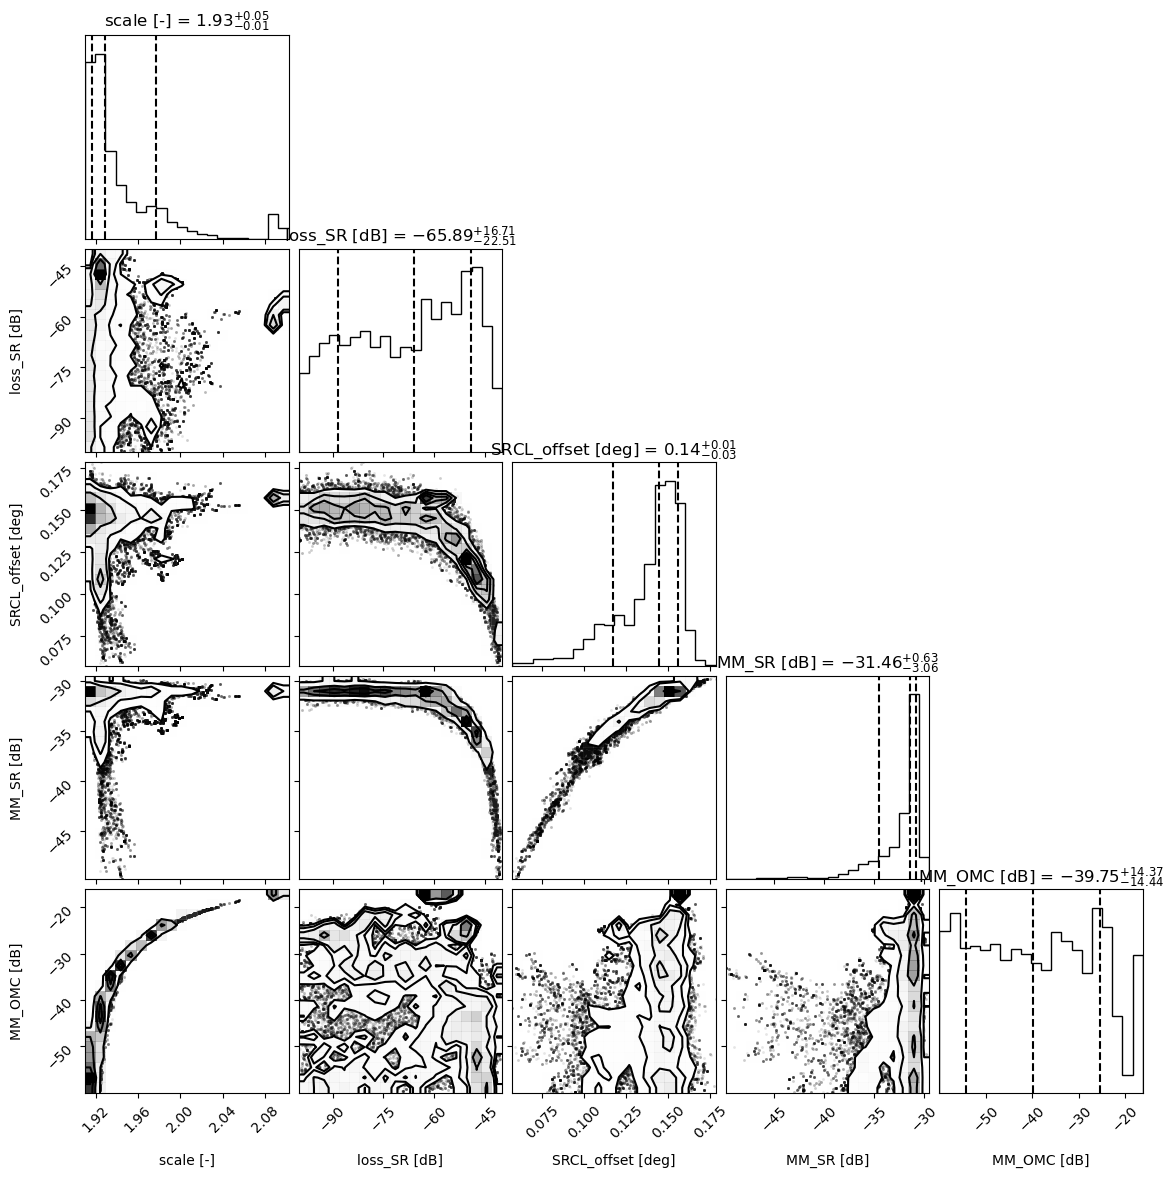

In [480]:
import corner

# Only take the samples after burning in the sampler to remove effects of initial conditions
nburn = 200
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
samples[:,2] = samples[:,2]*180/np.pi # convert SRCL detuning to deg

fig = corner.corner(samples, labels=['scale [-]', 'loss_SR [dB]', 'SRCL_offset [deg]', 'MM_SR [dB]', 'MM_OMC [dB]'],
                   quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12},);
fig.set_size_inches((12, 12));

In the case where thermal lensing is negligible, the MCMC constrains the scale and SRCL detuning pretty well. Other parameters like losses and mismatches are not well constrained as they could be anything. The $\Upsilon_{SR}$ already has upper bound to be more than -30 dB (3%), which is a reasonable non-ideality. Note that these degrees of freedom are not orthogonal with each other; we can see a strong correlation between scale factor and $\Upsilon_{OMC}$, SRCL detuning and $\Upsilon_{SR}$, etc. 

For the case of OPD=true where thermal lensing is dominant, the result is shown here

In [476]:
import emcee
import numpy as np
from gwinc.noise.quantum import shotrad_debug
from gwinc import load_budget
from numpy.random import randn, rand
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt


def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)

def model(theta, freq, ifo, key):
    for j in range(len(key)):
        if key[j] == 'scale':
            scale = theta[j]
        elif j == 2:
            ifo[key[j]] = theta[j]
        else:
            ifo[key[j]] = db2mag(theta[j])
    
    sr = shotrad_debug(freq, ifo)
    C = sr.d_sense
    C = scale*C*np.sqrt(50*1403/1000/1000) # W/m
    return C


def logFlatPrior(theta, bound):
    prior = -0.1
    for j in range(len(theta)):
        if theta[j] < bound[j][0] or theta[j] > bound[j][1]:
            #print(str(theta[j]) + " out of " + str(bound[j]))
            prior = -np.inf
    return prior


def logLike(theta, freq, ifo, key, data, relerr):
    mdl = model(theta, freq, ifo, key)
    # result = -np.sum(abs(data - mdl)**2)
    result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2))
    if np.isnan(result):
        result = -np.inf
    return result


def logPost(theta, freq, ifo, key, bound, data, relerr):
    result = logLike(theta, freq, ifo, key, data, relerr) + logFlatPrior(theta, bound)
    # if np.isnan(result):
    #     print(logLike(theta, freq, ifo, key, data))
    return result


ifo = load_budget('Aplus').ifo
ifo.Optics.is_OPD = True # default is False
ifo.Optics.ITM.Transmittance = 0.0148
ifo.Optics.ETM.Transmittance = 5e-6
ifo.Laser.ArmPower = 330e3; del ifo.Laser.Power
ifo.Optics.Quadrature.dc = np.pi / 180 * (90-11) # theta_LO
ifo.Squeezer.AmplitudedB = 0 # z_eff_dB
ifo.Optics.PhotoDetectorEfficiency = 1 - (0.025 + 0.01 + 800e-6 + 0.015 + 0.007 + 0.02)
ifo.Optics.MM_ARM_SRCphi = 0 *np.pi/180
ifo.Optics.MM_IFO_OMCphi = 0 *np.pi/180
ifo.Optics.SRM.SRCGouy_rad = 19 *np.pi/180


d = np.loadtxt('./data/0502_sensing_response_freq_real_imag_uncert.txt')
freq = d[:,0]
real = d[:,1]
imag = d[:,2]
relerr = d[:,3]

data = real + 1j*imag
data = data*10**(24/20)*1403/1000/1000 # W/m


theta = [
    2,
    db(500e-6),
    0.17*np.pi/180,
    db(0.001),
    db(0.07)
]

key = [
    'scale',
    'Optics.BSLoss',
    'Optics.SRM.Tunephase',
    'Optics.MM_ARM_SRC',
    'Optics.MM_IFO_OMC'
]

bound = [
    (1,10),
    (db(10e-6), db(0.01)),
    (-2*np.pi/180, 2*np.pi/180),
    (db(0.00001), db(0.01)),
    (db(0.001), db(0.3))
]



ndim = 5 # number of parameters to estimate
nwalkers = 30 # number of walkers
nsteps = 2000 # number of steps each walker will take
nburn = 0 # number of steps to "burn in"
nthreads = 3 # number of parallel threads to use



# Choose initial conditions
theta0 = np.array(
    [[theta[0] + 0.1*randn(), theta[1] + 20*randn(), theta[2] + 0.5*np.pi/180*randn(), theta[3] + 10*randn(), theta[4] + 10*randn()]
     for ii in range(nwalkers)])

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=(freq, ifo, key, bound, data, relerr), threads=nthreads);
sampler.run_mcmc(theta0, nsteps, store=True);

# Only take the samples after burning in the sampler to remove effects of initial conditions
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))


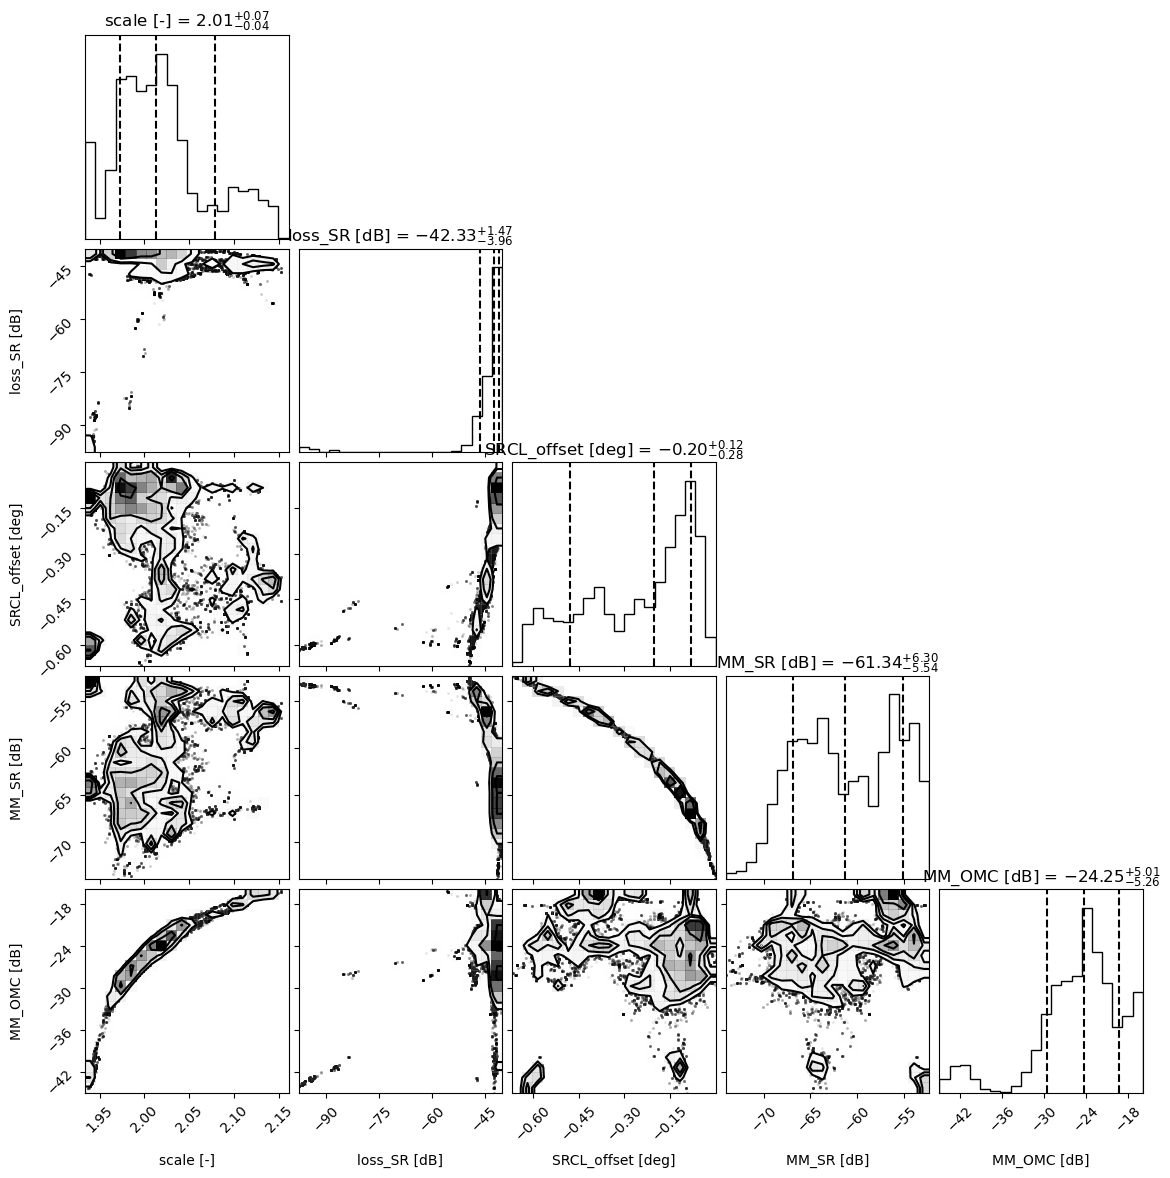

In [477]:
import corner

# Only take the samples after burning in the sampler to remove effects of initial conditions
nburn = 200
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
samples[:,2] = samples[:,2]*180/np.pi # convert SRCL detuning to deg

fig = corner.corner(samples, labels=['scale [-]', 'loss_SR [dB]', 'SRCL_offset [deg]', 'MM_SR [dB]', 'MM_OMC [dB]'],
                   quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12},);
fig.set_size_inches((12, 12));

In [ ]:
# Plotting the chain

chain = np.load('./fig/FIS/MCMC/Gaussian_prior/0514_11_theta_-11.7_chain.npy')
[nwalkers, nsteps, ndim] = chain.shape

fig = plt.figure(figsize=(11, 18));
gs = gridspec.GridSpec(5, 1, hspace=0.05);
ax0 = fig.add_subplot(gs[0]);
ax1 = fig.add_subplot(gs[1], sharex=ax0);
ax2 = fig.add_subplot(gs[2], sharex=ax0);
ax3 = fig.add_subplot(gs[3], sharex=ax0);
ax4 = fig.add_subplot(gs[4], sharex=ax0);

# num = nwalkers/2
num = nwalkers
for ii in range(num):
    ax0.plot(chain[ii, :, 0]);
    ax1.plot(chain[ii, :, 1]);
    ax2.plot(chain[ii, :, 2]);
    ax3.plot(chain[ii, :, 3]);
    ax4.plot(chain[ii, :, 4]);
# plt.setp(ax0.get_xticklabels(), visible=False);
# plt.setp(ax1.get_xticklabels(), visible=False);
# ax0.set_ylabel('scale');
# ax1.set_ylabel('loss_SR');
# ax2.set_ylabel('SRCL detuning [rad]');
# ax3.set_ylabel('MM_SR');
# ax4.set_ylabel('MM_OMC');
# ax4.set_xlabel('Frequency [Hz]');
# ax4.set_xlim(0, nsteps);
for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.grid('on', which='both', alpha=0.3);
    ax.grid(which='minor', alpha=0.2);
    

For the strong thermal lensing case, we've set the upper bound of $\Upsilon_{SR}$ to be -60 dB (0.1%). The distribution of the $\Upsilon_{SR}$ also shows that the likelihood of it being above -60 dB is very small. The scale factor and SRCL detuning is also constrained well. The SRCL detuning is estimated to be less than OPD=False case and it makes sense. The mismatches are still difficult to estimate because the contribution is likely to be the sum of quadratic mismatch and thermal lensing effect. In conclusion, we choose the default case where quadratic mismatch dominates and gives the most reasonable SRC parameters for later on analysis. 

The SRC parameters inferred from sensing functions are

| Parameter | MCMC result |
| :-: | :-: |
| Arm to SRC mode-mismatch | 2.8% |
| SRCL detuning | 0.14 degree |

# Parametric Study

GWINC mainly uses two parameters to calculate the amplitude of the coating thermal noise (CTN). The loss angle of the high-index material and the loss angle of the low-index material. Besides, the slope of the high-index material can also be used to fit the slope of the measured CTN.

Here's the parametric study of these three parameters:

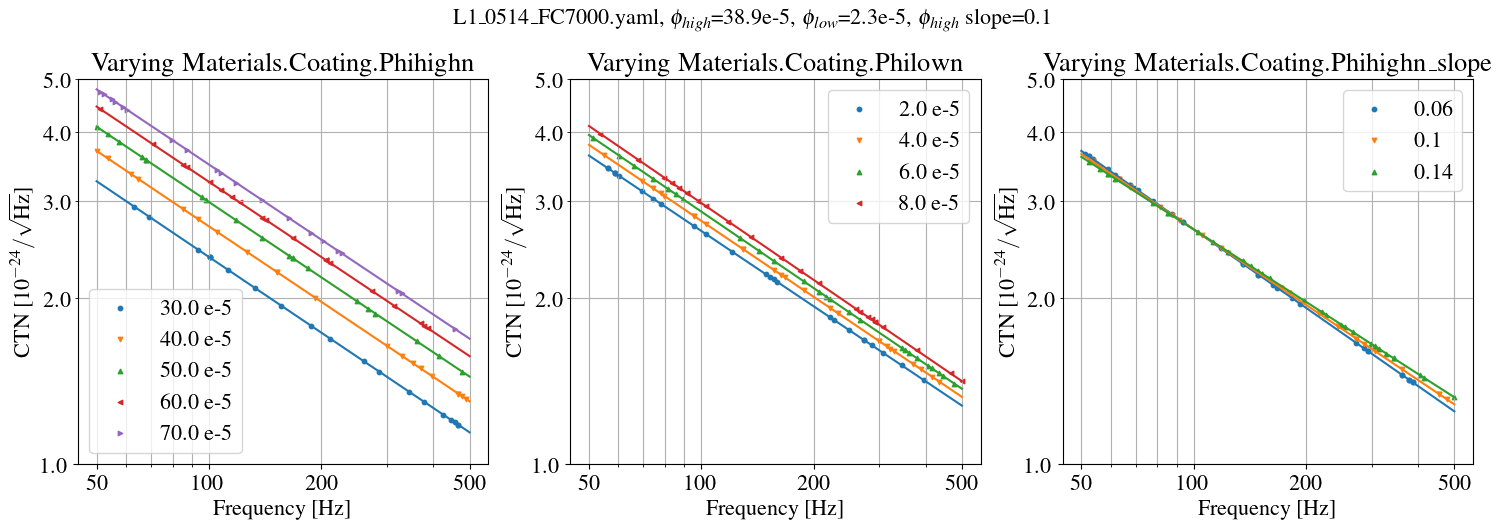

In [54]:
import matplotlib.pyplot as plt
import numpy as np


def plotUnsqzC(param, yaxis, title):
    paramName = param['Name']
    paramList = param['List']
    paramLabel = param['Label']
    paramUnit = param['Unit']
    
    yscale = yaxis['Scale']
    yscalenum = yaxis['ScaleNum']
    ylabel0 = yaxis['Label0']
    
    title0 = 'Varying ' + paramName + title
    filename = './fig/C/C_' + paramName + '.pdf';
    
    freq = np.geomspace(50, 500, 100);

    budget = gwinc.load_budget('L1_0514_FC7000.yaml')
    ifo = budget.ifo
    
    Slist = list();
    for j in range(len(paramList)):
        ifo[paramName] = paramList[j]
        trace = budget.run(freq=freq, ifo=ifo)
        Slist.append(trace.CoatingBrownian.psd);


    markerType = ['o', 'v','^', '<', '>', 's', 'p', '*', '+', 'x', 'd']

    density = 1 # scaling 
    num = np.int64(len(freq)/len(Slist)*density)

    for j in range(len(paramList)):
        data = np.sqrt(Slist[j])
        plt.loglog(freq, data/yscalenum, linewidth=1.5);
        id = np.int64(np.ceil(np.random.rand(num)*len(data))) - 1
        plt.scatter(freq[id], data[id]/yscalenum, marker=markerType[j%len(markerType)],
                    s=10, label=str(paramLabel[j])+' '+paramUnit)


    plt.xlabel('Frequency [Hz]'); plt.ylabel(ylabel0); 
    # plt.xscale("log")
    plt.yscale(yscale)
    ax = plt.gca()
    ax.yaxis.set_minor_formatter('{x:.1f}')
    ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    # ax.set_xticks([20,50,100,200,500,1000,2000], ('20','50','100','200','500','1000','2000'))
    plt.xticks([50,100,200,500], ('50','100','200','500'))
    plt.ylim(1, 5)
    plt.legend()
    plt.title(title0)
    # plt.savefig(filename)
    # plt.show()




yaxis = {
    'Scale': 'log',
    'ScaleNum': 1e-24,
    'Label0': 'CTN [$10^{-24}/\mathrm{\sqrt{Hz}}$]'
}

ifo = gwinc.load_budget('L1_0514_FC7000.yaml').ifo

title = 'L1_0514_FC7000.yaml, ' + r'$\phi_{high}$=' + str(round(ifo.Materials.Coating.Phihighn*1e5,2)) + 'e-5, ' \
    + r'$\phi_{low}$=' + str(round(ifo.Materials.Coating.Philown*1e5,2)) + 'e-5, ' \
    + r'$\phi_{high}$ slope=' + str(round(ifo.Materials.Coating.Phihighn_slope,2))
    # + str(ifo.Squeezer.AmplitudedB) + 'dB generated, ' \
    # + '$\phi_{rms}$=' + str(ifo.Squeezer.SQZAngleRMS*1000) +'mrad, ' + '$\Lambda_{inj}=$' + str(round(ifo.Squeezer.InjectionLoss*100,2)) + '%, ' \
    # + r'$\Upsilon_{SQZ}$=(' + str(round(ifo.Squeezer.MM_SQZ_OMC*100,2)) + '%, ' + str(ifo.Squeezer.MM_SQZ_OMCphi*180/np.pi) + '$^{\circ}$)\n' \
    # + r'$\theta_{LO}$=-11$^{\circ}$, $P_{arm}$=' + str(round(ifo.Laser.ArmPower/1e3)) + 'kW, ' + '$\Lambda_{RO}$=' + str(round((1-ifo.Optics.PhotoDetectorEfficiency)*100, 2)) +'%, '\
    # + r'$\Upsilon_{OMC}$=(' + str(round(ifo.Optics.MM_IFO_OMC*100,2)) + '%, ' + str(ifo.Optics.MM_IFO_OMCphi*180/np.pi) + '$^{\circ}$)\n'\
    # + r'$\psi_{SR}$= ' + str(ifo.Optics.SRM.SRCGouy_rad*180/np.pi) + '$^{\circ}$, ' + '$\Delta \phi_{SR}$=' + str(round(ifo.Optics.SRM.Tunephase*180/np.pi, 2)) + '$^{\circ}$, '\
    # + 'OPD=' + str(ifo.Optics.is_OPD) + ', ' + '$\Lambda_{SR}$=' + str(round(ifo.Optics.BSLoss*1e6)) + ' ppm, '\
    # + r'$\Upsilon_{SR}$=(' + str(round(ifo.Optics.MM_ARM_SRC*100,2)) + '%, ' + str(ifo.Optics.MM_ARM_SRCphi*180/np.pi) + '$^{\circ}$)\n'\
# filename = 'is_OPD_mm_SR_.001_mm_OMC_.05'

title0 = ''

plt.figure(1)

# plt.subplot(331)
# param = {
#     'Name': 'Optics.Quadrature.dc',
#     'List': np.pi / 180 * (90 + np.arange(-20,20 +5,5)),
#     'Label': np.arange(-20,20 +5,5),
#     'Unit': 'deg'
# }
# plotUnsqzC(param, yaxis, title0)

plt.subplot(131)
paramList = np.arange(30, 80, 10)*1e-5
param = {
    'Name': 'Materials.Coating.Phihighn',
    'List': paramList,
    'Label': paramList/1e-5,
    'Unit': 'e-5'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(132)
paramList = np.arange(2, 10, 2)*1e-5
param = {
    'Name': 'Materials.Coating.Philown',
    'List': paramList,
    'Label': paramList/1e-5,
    'Unit': 'e-5'
}
plotUnsqzC(param, yaxis, title0)

plt.subplot(133)
paramList = np.arange(0.06, 0.18, 0.04).round(2)
param = {
    'Name': 'Materials.Coating.Phihighn_slope',
    'List': paramList,
    'Label': paramList,
    'Unit': ''
}
plotUnsqzC(param, yaxis, title0)


fig = plt.gcf()
fig.set_size_inches(18, 5)
fig.suptitle(title, y=1.02, fontsize=16)
# plt.savefig('./fig/C/C_' + filename + '.pdf')
plt.show()

# paramName = 'L_SR_rms';
# paramList = logspace(-12, -6, 7);
# paramName = 'T_SR';
# paramList = 0.31:0.005:0.34;
# paramName = 'z_eff_dB';
# paramList = 10:2:18;
# paramName = 'loss_INJ_unknown';
# paramList = 0.05:0.02:0.12;
# paramName = 'phaseNoise';
# paramList = (100:100:1000)*1e-3;
# paramName = 'mm_SQZ2OMC';
# paramList = 0:0.025:0.20; 



The loss angles for high and low materials are close to being degenerate. We will verify this in MCMC.

# Infer Non-QN from Subtracting QN

One way to infer IFO and SQZ parameters is to fit DARM difference. The result is stored in ```L1_0514_FC7000.yaml```

In [67]:
modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'
unsfile = './data/0514_all_Unsqz_FCmis_LOonCLF.h5'
fdsfile = './data/0514_22_FDS.h5'


D_r = lib.DARM(unsfile); D_r.relerr_n = D_r.relerrD_n; D_r.relerr_p = D_r.relerrD_p
D_r.calcErr(); # D_r.removeLines('DARM'); 
D_r_psd = deepcopy(D_r)


# M = np.load('./fig/FIS/MCMC/all/FitmmPsiOMC/S_med.npy')
# budget = gwinc.load_budget('Aplus')
# init(budget)
budget = gwinc.load_budget('./L1_0514_FC7000.yaml')
ifo = budget.ifo
ifo.Squeezer.Type = 'None'
trace = budget.run(freq=D_r.f, ifo=ifo)
M_psd = lib.DARM()
M_psd.f = D_r.f
M_psd.S = trace.Quantum.psd

C = D_r - M_psd
C_psd = D_r - M_psd


# psd plot
freq = np.geomspace(20,2000,500)
D_r_psd.rebin_log(freq)
# D_s_psd.rebin_log(freq)
C_psd.rebin_log(freq)


# dot with errbar plot
freq = np.geomspace(50,500,50)

D_r.removeLines('DARM'); D_r.rebin_log(freq)

N = deepcopy(C)
N.relerr_n = D_r.relerrN_n
N.relerr_p = D_r.relerrN_p
N.calcErr(); N.removeLines('DARM'); N.rebin_log(freq)

# M.setZeroErr(); M.calcErr(); M.removeLines('DARM'); M.rebin_log(freq)
trace = budget.run(freq=freq, ifo=ifo);
M = lib.DARM(); M.f = freq
M.S = trace.Quantum.psd
(relerrM_n, relerrM_p) = np.load(modelerrfile)
modelf = np.geomspace(20,2000,100)
relerrM_n = np.interp(M.f, modelf, relerrM_n)
relerrM_p = np.interp(M.f, modelf, relerrM_p)
M.relerr_n = relerrM_n; M.relerr_p = relerrM_p
M.calcErr(); 

C.calcErr();
C.removeLines('DARM'); C.rebin_log(freq)

G = lib.DARM(); G.f = freq
G.err_n = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_n)
G.err_p = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_p)


C.err_n = np.sqrt( (D_r.err_n)**2 + (N.err_n)**2 + (M.err_n)**2 + (G.err_n)**2 )
C.err_p = np.sqrt( (D_r.err_p)**2 + (N.err_p)**2 + (M.err_p)**2 + (G.err_p)**2 )


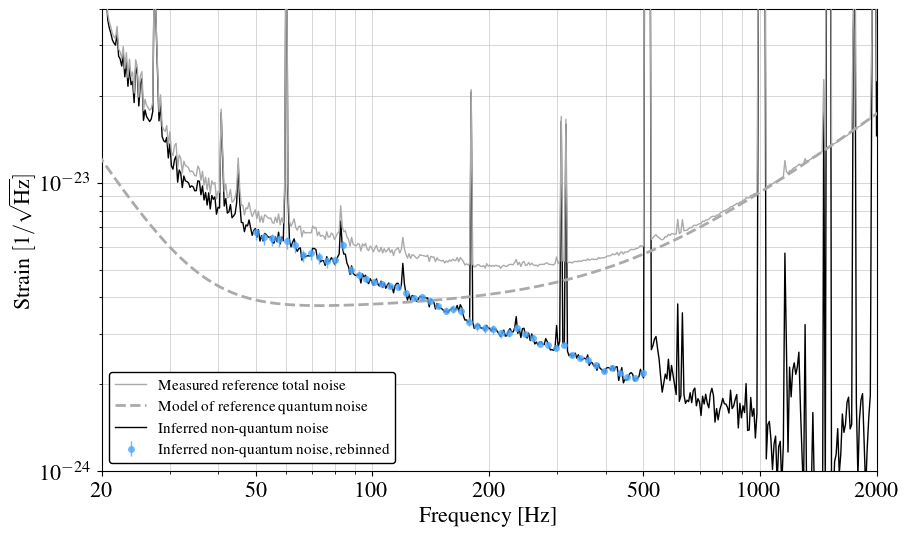

In [68]:
fontscale = 1.0
matplotlib.rc('font',**{'family':'serif','serif':['Times'], 'size':16*fontscale})

PRXcolor = np.array([173,3,222])/255
# sqzcolor = PRXcolor
sqzcolor = 'mediumorchid'
# sqlcolor = np.array([200,10,10])/255
# sqlcolor2 = np.array([242,158,142])/255
sqlcolor = 'orangered'
sqlcolor2 = 'lightsalmon'
l1color = [75/255,166/255,255/255] # From O3 instrument paper
grayrgb = 170
gray = [grayrgb/255,grayrgb/255,grayrgb/255]

fig, ax = plt.subplots()

ax.errorbar(C.f, np.sqrt(abs(C.S)), [C.err_n, C.err_p]/(2*np.sqrt(abs(C.S))), ecolor=l1color, marker='o', markerfacecolor=l1color, alpha=0.8,
             ms=5,ls='-',lw=0,c=l1color, elinewidth=1,capsize=0,mew=0,zorder=20,label='Inferred non-quantum noise, rebinned')

budget = gwinc.load_budget('L1_0514_FC7000.yaml')


ax.loglog(D_r_psd.f, np.sqrt(D_r_psd.S), c=gray, label = 'Measured reference total noise',linewidth = 1,zorder=10)
# ax.loglog(D_s.f, np.sqrt(D_s.S),c=sqzcolor,label = 'Measured squeezed total noise',linewidth = 1,zorder=15)
ax.loglog(M_psd.f, np.sqrt(M_psd.S),c=gray, linestyle='--', lw = 2.0,label='Model of reference quantum noise',zorder=10)

ax.loglog(C_psd.f, np.sqrt(abs(C_psd.S)), c='black', lw = 1,label='Inferred non-quantum noise', zorder = 5)


ax.set_xticks([20,50,100,200,500,1000,2000], ('20','50','100','200','500','1000','2000'))
ax.set_xlim(20, 2000); ax.set_ylim(1e-24, 4e-23)

grayrgb = 200
ax.grid(True, which='both', color=[grayrgb/255,grayrgb/255,grayrgb/255], linestyle='-', linewidth=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], edgecolor="black", 
                   fontsize=11*fontscale, loc='best')

# legend = ax.legend(edgecolor="black", fontsize=10)
legend.set_zorder(100)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor('white')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Strain $\mathrm{[1/\sqrt{Hz}]}$')
# ax.set_title(fdsfile)

# arrowx = np.exp((np.log(20)+np.log(30))/2)
# arrowy1 = np.sqrt(8*scipy.constants.hbar/40/(2*np.pi*arrowx)**2)/4000
# arrowy2 = np.sqrt(8*scipy.constants.hbar/40/(2*np.pi*arrowx)**2)/4000/10**(3/20)
# plt.annotate(text='', xy=(arrowx,arrowy1), xytext=(arrowx,arrowy2), arrowprops=dict(arrowstyle='<->'))


fig.set_size_inches(10, 6)

# plt.savefig('./fig/moneyplot.svg')
# plt.savefig('./fig/moneyplot.pdf')
plt.show()

The uncertainty budget is plotted below

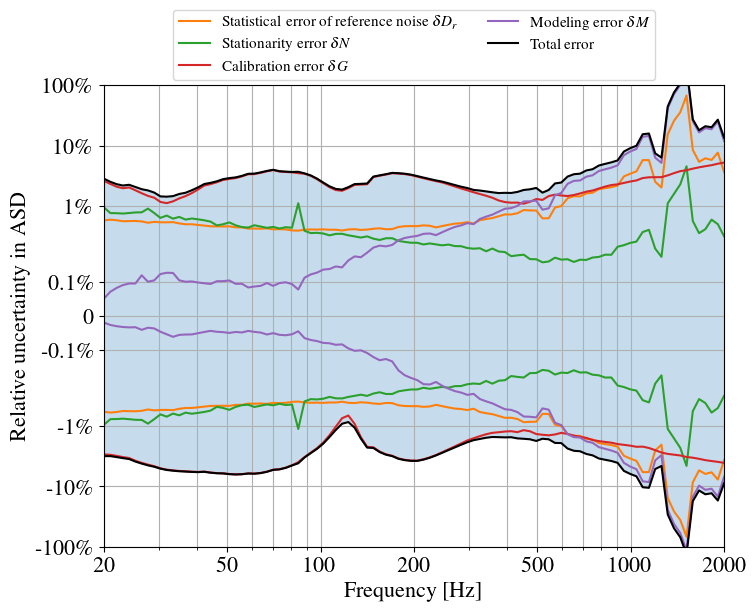

In [18]:
fig, ax = plt.subplots()


colors = ['tab:blue',
         'tab:orange',
         'tab:green',
         'tab:red',
         'tab:purple',
         'tab:cyan']


zeros = C.f*0

C.err_n = np.sqrt( (D_r.err_n)**2 + (N.err_n)**2 + (M.err_n)**2 + (G.err_n)**2 )


# ax.plot(C.f, abs(D_s.err_p)/(2*abs(Q.S)), c=colors[0], label=r'Statistical error of squeezed noise $\delta D_s$')
ax.plot(C.f, abs(D_r.err_p)/(2*abs(C.S)), c=colors[1], label=r'Statistical error of reference noise $\delta D_r$')
ax.plot(C.f, abs(N.err_p)/(2*abs(C.S)), c=colors[2], label=r'Stationarity error $\delta N$')
ax.plot(C.f, abs(G.err_p)/(2*abs(C.S)), c=colors[3], label=r'Calibration error $\delta G$')
ax.plot(C.f, abs(M.err_p)/(2*abs(C.S)), c=colors[4], label='Modeling error $\delta M$')
ax.plot(C.f, C.err_p/(2*abs(C.S)), c='black', label='Total error')





# ax.plot(C.f, -abs(D_s.err_n)/(2*abs(Q.S)), c=colors[0])
ax.plot(C.f, -abs(D_r.err_n)/(2*abs(C.S)), c=colors[1])
ax.plot(C.f, -abs(N.err_n)/(2*abs(C.S)), c=colors[2])
ax.plot(C.f, -abs(G.err_n)/(2*abs(C.S)), c=colors[3])
ax.plot(C.f, -abs(M.err_n)/(2*abs(C.S)), c=colors[4])
ax.plot(C.f, -C.err_n/(2*abs(C.S)), c='black')
ax.fill_between(C.f, -C.err_n/(2*abs(C.S)), C.err_p/(2*abs(C.S)), where = -C.err_n/(2*abs(C.S))< C.err_p/(2*abs(C.S)), alpha = 0.25, interpolate=True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2, fontsize=11)


# ax2.xlabel('Frequency [Hz]'); 
ax.set_ylabel('Relative uncertainty in ASD'); 
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=0.002)
# ax = ax2.gca()
# ax.yaxis.set_minor_formatter('{x:.1f}')
# ax.yaxis.set_major_formatter('{x:.1f}')
ax.grid(True, which='both')
# ax2.legend()
# ax2.title(titles[j])
ax.set_yticks([-1,-0.1,-0.01,-0.001,0.001,0,0.01,0.1,1], ['-100\%', '-10\%', '-1\%', '-0.1\%', '0.1\%', '0', '1\%', '10\%', '100\%'])
ax.set_xticks([20,50,100,200,500,1000,2000], ('20','50','100','200','500','1000','2000'))
ax.set_xlim(20, 2000); ax.set_ylim(-1, 1)



# plt.setp(ax2.get_xticklabels(), visible=False);
plt.xlabel('Frequency [Hz]')
fig.set_size_inches(8, 6)

# plt.savefig('./fig/errbudget.svg')
# plt.savefig('./fig/errbudget.pdf', bbox_inches="tight")
plt.show()

It's mostly dominated by the calibration error at relevant frequencies.

These two loss angles are very degenerate with each other. Therefore, we will only fit loss angle of high-index material. 

In [108]:
def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)
  

    
def getdata(freq, filelist):
    # print(filelist)
    direc = './data/';
    ext = '.h5'
    
    modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'

    Slist = np.array([])
    relerrlist = np.array([])
    freqlist = np.array([])
    filelist = [filelist]
    
    for file in filelist:
        unsfile = file
        # print(unsfile)
        D_r = lib.DARM(direc+unsfile+ext); D_r.relerr_n = D_r.relerrD_n; D_r.relerr_p = D_r.relerrD_p
        D_r.calcErr(); # D_r.removeLines('DARM'); 
        
        budget = gwinc.load_budget('./L1_0514_FC7000.yaml')
        ifo = budget.ifo
        ifo.Squeezer.Type = 'None'
        trace = budget.run(freq=D_r.f, ifo=ifo)
        M_psd = lib.DARM()
        M_psd.f = D_r.f
        M_psd.S = trace.Quantum.psd

        C = D_r - M_psd

        # freq = np.geomspace(50,500,50)

        D_r.removeLines('DARM'); D_r.rebin_log(freq)

        N = deepcopy(C)
        N.relerr_n = D_r.relerrN_n
        N.relerr_p = D_r.relerrN_p
        N.calcErr(); N.removeLines('DARM'); N.rebin_log(freq)

        # M.setZeroErr(); M.calcErr(); M.removeLines('DARM'); M.rebin_log(freq)
        trace = budget.run(freq=freq, ifo=ifo);
        M = lib.DARM(); M.f = freq
        M.S = trace.Quantum.psd
        (relerrM_n, relerrM_p) = np.load(modelerrfile)
        modelf = np.geomspace(20,2000,100)
        relerrM_n = np.interp(M.f, modelf, relerrM_n)
        relerrM_p = np.interp(M.f, modelf, relerrM_p)
        M.relerr_n = relerrM_n; M.relerr_p = relerrM_p
        M.calcErr(); 

        C.calcErr();
        C.removeLines('DARM'); C.rebin_log(freq)

        G = lib.DARM(); G.f = freq
        G.err_n = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_n)
        G.err_p = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_p)


        C.err_n = np.sqrt( (D_r.err_n)**2 + (N.err_n)**2 + (M.err_n)**2 + (G.err_n)**2 )
        C.err_p = np.sqrt( (D_r.err_p)**2 + (N.err_p)**2 + (M.err_p)**2 + (G.err_p)**2 )

        
        Slist = np.concatenate((Slist, C.S), axis=0)
        relerrlist = np.concatenate((relerrlist, (C.err_n + C.err_p)/2/C.S), axis=0)
        # freqlist = np.concatenate((freqlist, np.concatenate((freq, freq), axis=0)), axis=0)


    data = Slist
    relerr = relerrlist
    return (data, relerr)
    
    
def model(param, freq, budget, key):
    
    ifo = budget.ifo
    ifo[key[0]] = db2mag(param[0]) # phi_highn
    # ifo[key[1]] = db2mag(param[1]) # phi_lown
    ifo[key[1]] = db2mag(param[1]) # phi_highn slope

    trace = budget.run(freq=freq, ifo=ifo)
    return trace.CoatingBrownian.psd
    # return np.concatenate((S_diff, S_shot), axis=0)


# def logFlatPrior(param, bound):
#     prior = 0
#     for j in range(len(param)):
#         if param[j] < bound[j][0] or param[j] > bound[j][1]:
#             #print(str(param[j]) + " out of " + str(bound[j]))
#             prior = -np.inf
#     return prior

def logGaussianPrior(param, bound): # bound[0] and bound[1] are +- sigma
    prior = 0
    for i in range(len(param)):
        mu = (bound[i][0]+bound[i][1])/2
        sigma = abs(bound[i][1]-mu)
        prior += np.log(1.0/(np.sqrt(2*np.pi*sigma**2)))-0.5*(param[i]-mu)**2/sigma**2
    return prior


def logLike(param, freq, budget, key, data, relerr):
    mdl = model(param, freq, budget, key)
    result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)
    # result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2)
    if np.isnan(result):
        result = -np.inf
    return result


def logPost(param, freq, budget, key, bound, data, relerr):
    result = logLike(param, freq, budget, key, data, relerr) + logGaussianPrior(param, bound)
    # if np.isnan(resut):
    #     print(logLike(param, freq, ifo, key, data))
    return result


def pltmcmcsetup(param, bound, xlabel):
    plt.hist(param, density=True, label='Initial walkers')
    mu = (bound[1]+bound[0])/2
    sigma = abs(bound[1]-bound[0])/2
    x = np.linspace(mu-2.5*sigma, mu+2.5*sigma, 100)
    plt.plot(x, 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2), '-', label='Prior')
    plt.plot([mu-sigma,mu-sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black', label='Prior $\pm 1 \sigma$')
    plt.plot([mu+sigma,mu+sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black')
    # plt.yscale(yscale)
    # ax = plt.gca()
    # ax.yaxis.set_minor_formatter('{x:.1f}')
    # ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    plt.xlabel(xlabel)
    # plt.legend()
    # plt.title(title0)
    
    

def mcmc(result_queue, filelist, param0):
    # freq = np.geomspace(20,2000,100)
    freq = np.geomspace(50,500,50)
    [data, relerr] = getdata(freq, filelist)
    
    budget = gwinc.load_budget('L1_0514_FC7000.yaml')
    ifo = budget.ifo
    
    key = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
    
    bound = [
        (db(30e-5), db(90e-5)), # phi_highn
        # (db(2e-5), db(10e-5)), # phi_lown
        (db(0.05), db(0.15)), # phi_highn slope
    ]

    [nwalkers, ndim] = param0.shape
    nsteps = 10000 # number of steps each walker will take
    nthreads = 16 # number of parallel threads to use
    
    print('Start MCMC')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=(freq, budget, key, bound, data, relerr), threads=nthreads);
    sampler.run_mcmc(param0, nsteps, store=True, skip_initial_state_check=True);

    samples = sampler.chain
    # np.save(folder + 'chain_' + str(round(rand()*10000000)) + '.npy', samples.astype(np.float32))
    result_queue.put((samples, True))


def main():
    filelist = [
        '0514_all_Unsqz_FCmis_LOonCLF'
    ]

    
    folder = './'
    temp = np.linspace(1,100,100)
    np.save(folder + 'test.npy', temp.astype(np.float32))
    
    
    start = time.time()
    
    for file in filelist:
        
        budget = gwinc.load_budget('L1_0514_FC7000.yaml')
        ifo = budget.ifo

        key = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
        ]

        ndim = len(key) # number of parameters to estimate
        ncores = multiprocessing.cpu_count()
        ncores = 16
        print('Total ' + str(ncores) + ' CPU cores')
        nwalkerPerCore = ndim*2
        nwalkers = ncores*nwalkerPerCore # number of walkers


        # Choose initial conditions

        # print('Max likelihood = ' + str(-np.sum(np.log(2*np.pi*abs(data*relerr)**2)/2)))
        # defaultLike = logLike(param, freq, budget, key, data, relerr)
        # print('Initial default likelihood is '+str(defaultLike))


        bound0 = [
            (db(30e-5), db(90e-5)), # phi_highn
            # (db(2e-5), db(10e-5)), # phi_lown
            (db(0.05), db(0.15)), # phi_highn slope
        ]



        # param0 = np.array(
        #     [[(bound0[i][1]+bound0[i][0])/2 + abs((bound0[i][1]-bound0[i][0])/2)*randn()
        #      for i in range(ndim)]
        #     for ii in range(nwalkers)]) 

        param0 = np.array(
            [[bound0[i][0] + (bound0[i][1]-bound0[i][0])*rand()
             for i in range(ndim)]
            for ii in range(nwalkers)]) 


        result_queue = multiprocessing.Queue()
        workers = []
        for i in range(ncores):
            worker = multiprocessing.Process(
                target=mcmc, args=(result_queue, file, param0[i*nwalkerPerCore:(i+1)*nwalkerPerCore, :])
            )
            # print('Start '+str(i))
            worker.start()
            workers.append(worker)

        finished = 0
        while True:
            try:
                chain, result = result_queue.get(timeout=0.1)
                if result:
                    finished += 1
                    print(str(finished) + " cores finished!")
                    if finished == 1:
                        chains = chain
                    else:
                        chains = np.concatenate((chains, chain), axis=0)
                    if finished == ncores:
                        break
            except KeyboardInterrupt:
                break
            except (multiprocessing.TimeoutError, queue.Empty):
                pass
        for worker in workers:
            worker.kill()

        
        np.save(folder + file + '.npy', chains.astype(np.float32))
        
    end = time.time()
    print(str((end - start)/60) + ' min')

if __name__ == "__main__":
    main()

Total 16 CPU cores
Start MCMC
Start MCMC
Start MCMC
Start MCMCStart MCMC

Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
1 cores finished!
2 cores finished!
3 cores finished!
4 cores finished!
5 cores finished!
6 cores finished!
7 cores finished!
8 cores finished!
9 cores finished!
10 cores finished!
11 cores finished!
12 cores finished!
13 cores finished!
14 cores finished!
15 cores finished!
16 cores finished!
80.74626071055731 min


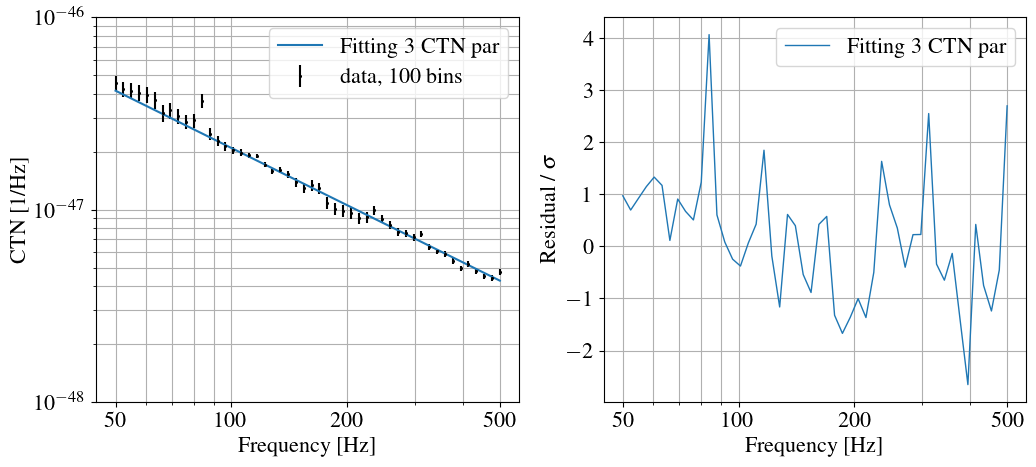

In [110]:
import lib, importlib; importlib.reload(lib)


folder1 = './'
# import fig.FIS.MCMC.Gaussian_prior.Parm_270kW.NoRebinDeltaG.MCMC_FIS as mcmc1
# importlib.reload(mcmc1)
key1 = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
freq1 = np.geomspace(50,500,50)
label1 = r'Fitting 3 CTN par'

unsfile = '0514_all_Unsqz_FCmis_LOonCLF'
budget = gwinc.load_budget('./L1_0514_FC7000.yaml')

result = []; result_n = []; result_p = []; likelihood = []; likelihood_l = [];
i = 0



nburn = 2000

plt.subplot(1, 2, 1)
chain = np.load(folder1+unsfile+'.npy')
[nwalkers, nsteps, ndim] = chain.shape
samples = chain[:, nburn:, :].reshape((-1, ndim))

mdl = model(np.median(samples, axis=0), freq1, budget, key1)
[data, relerr] = getdata(freq1, unsfile)
plt.errorbar(freq1, abs(data), abs(data)*[relerr, relerr], marker='*', ms=1.75, color='black',
             ls='-', lw=0, elinewidth=1.5, label='data, 100 bins')
plt.loglog(freq1, abs(mdl), label=label1)
plt.subplot(1, 2, 2)
plt.semilogx(freq1, (data-mdl)/abs(data*relerr), 'o-', ms=0, lw=1.0, label=label1)



plt.subplot(1, 2, 1)
plt.xscale('log'); plt.yscale('log')
# plt.xlim(50, 500); 
plt.ylim(1e-48, 1e-46)
# plt.xlim(2000, 3000); plt.ylim(2e-23, 3e-23)
plt.xticks([50,100,200,500], ('50','100','200','500'))
plt.xlabel('Frequency [Hz]'); 
plt.ylabel(r'CTN [1/Hz]')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.legend()
plt.grid(which='both')


plt.subplot(1, 2, 2)
# plt.semilogx(freq, data-mdl)
# plt.xscale('log'); plt.yscale('log')
# plt.xlim(50, 500); 
plt.xticks([50,100,200,500], ('50','100','200','500'))
# plt.ylabel('Residual [$\sigma$]')
plt.ylabel('Residual / $\sigma$')
# plt.ylim(-20, 20)
# plt.xlim(2000, 3000); plt.ylim(2e-23, 3e-23)
plt.xlabel('Frequency [Hz]'); 
# plt.ylabel(r'Relative residual [%]')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.legend()
plt.grid(which='both')


fig = plt.gcf()
# fig.set_size_inches(20,6)
fig.set_size_inches(12,5)
# fig.suptitle(title, y=0.95, fontsize=10)
# plt.savefig('./result.pdf')
plt.show()

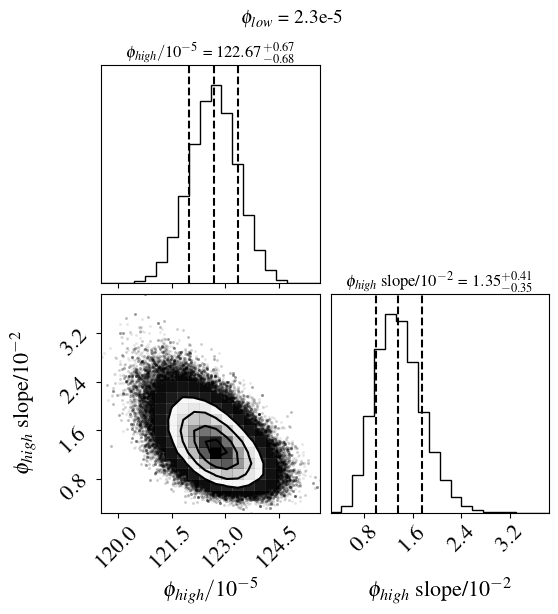

In [117]:
def convertUnit(samples, key):
    for i in range(len(key)):
        k = key[i]
        if k == 'Squeezer.SQZAngle' or k == 'Optics.SRM.SRCGouy_rad' or k == 'Optics.MM_IFO_OMCphi' or k == 'Optics.MM_ARM_SRCphi' or k == 'Squeezer.MM_SQZ_OMCphi' or k == 'Squeezer.FilterCavity.psi_mm':
            # print('Squeezer.SQZAngle')
            samples[:,i] = samples[:,i]*180/np.pi
        if k == 'Optics.SRM.Tunephase':
            samples[:,i] = db2mag(samples[:,i])*180/np.pi
        if k == 'Laser.ArmPower':
            # print('Laser.ArmPower')
            samples[:,i] = db2mag(samples[:,i])/1000
        if k == 'Optics.PhotoDetectorEfficiency' or k == 'Optics.MM_IFO_OMC' or k == 'Squeezer.FilterCavity.L_mm' or k == 'Squeezer.InjectionLoss' or k == 'Optics.MM_ARM_SRC' or k == 'Squeezer.MM_SQZ_OMC':
            # print('Optics.PhotoDetectorEfficiency')
            samples[:,i] = db2mag(samples[:,i])*100
        if k == 'Squeezer.SQZAngleRMS':
            # print('Squeezer.SQZAngleRMS')
            samples[:,i] = db2mag(samples[:,i])*1000
        if k == 'Squeezer.FilterCavity.Ti' or k == 'Squeezer.FilterCavity.Lrt' or k == 'Optics.BSLoss':
            # print('Squeezer.FilterCavity.Lrt')
            samples[:,i] = db2mag(samples[:,i])*1e6
        if k == 'Squeezer.FilterCavity.Lrms':
            samples[:,i] = db2mag(samples[:,i])*1e12
        if k == 'Materials.Coating.Phihighn' or k == 'Materials.Coating.Philown':
            samples[:,i] = db2mag(samples[:,i])*1e5
        if k == 'Materials.Coating.Phihighn_slope':
            samples[:,i] = db2mag(samples[:,i])*1e2
    return samples


[nwalkers, nsteps, ndim] = chain.shape
samples = chain[:, nburn:, :].reshape((-1, ndim))
samples = convertUnit(samples, key1)

fig = corner.corner(samples, labels=['$\phi_{high}/10^{-5}$', '$\phi_{high}$ slope/$10^{-2}$'],
                   quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});
fig.suptitle('$\phi_{low}$ = 2.3e-5', y=1.02, fontsize=14)
fig.set_size_inches((6, 6));

The MCMC looks good. We could also try to infer the CTN with the phenomenological equation:

$$S_{CTN} = N_{CTN} \left( \frac{100 \ \text{Hz}}{f}\right)^{m}$$

In [136]:
def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)
  

    
def getdata(freq, filelist):
    # print(filelist)
    direc = './data/';
    ext = '.h5'
    
    modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'

    Slist = np.array([])
    relerrlist = np.array([])
    freqlist = np.array([])
    filelist = [filelist]
    
    for file in filelist:
        unsfile = file
        # print(unsfile)
        D_r = lib.DARM(direc+unsfile+ext); D_r.relerr_n = D_r.relerrD_n; D_r.relerr_p = D_r.relerrD_p
        D_r.calcErr(); # D_r.removeLines('DARM'); 
        
        budget = gwinc.load_budget('./L1_0514_FC7000.yaml')
        ifo = budget.ifo
        ifo.Squeezer.Type = 'None'
        trace = budget.run(freq=D_r.f, ifo=ifo)
        M_psd = lib.DARM()
        M_psd.f = D_r.f
        M_psd.S = trace.Quantum.psd

        C = D_r - M_psd

        # freq = np.geomspace(50,500,50)

        D_r.removeLines('DARM'); D_r.rebin_log(freq)

        N = deepcopy(C)
        N.relerr_n = D_r.relerrN_n
        N.relerr_p = D_r.relerrN_p
        N.calcErr(); N.removeLines('DARM'); N.rebin_log(freq)

        # M.setZeroErr(); M.calcErr(); M.removeLines('DARM'); M.rebin_log(freq)
        trace = budget.run(freq=freq, ifo=ifo);
        M = lib.DARM(); M.f = freq
        M.S = trace.Quantum.psd
        (relerrM_n, relerrM_p) = np.load(modelerrfile)
        modelf = np.geomspace(20,2000,100)
        relerrM_n = np.interp(M.f, modelf, relerrM_n)
        relerrM_p = np.interp(M.f, modelf, relerrM_p)
        M.relerr_n = relerrM_n; M.relerr_p = relerrM_p
        M.calcErr(); 

        C.calcErr();
        C.removeLines('DARM'); C.rebin_log(freq)

        G = lib.DARM(); G.f = freq
        G.err_n = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_n)
        G.err_p = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_p)


        C.err_n = np.sqrt( (D_r.err_n)**2 + (N.err_n)**2 + (M.err_n)**2 + (G.err_n)**2 )
        C.err_p = np.sqrt( (D_r.err_p)**2 + (N.err_p)**2 + (M.err_p)**2 + (G.err_p)**2 )

        
        Slist = np.concatenate((Slist, C.S), axis=0)
        relerrlist = np.concatenate((relerrlist, (C.err_n + C.err_p)/2/C.S), axis=0)
        # freqlist = np.concatenate((freqlist, np.concatenate((freq, freq), axis=0)), axis=0)


    data = Slist
    relerr = relerrlist
    return (data, relerr)
    
    
def model(param, freq, budget, key):
    return (db2mag(param[0])*(100/freq)**db2mag(param[1]))**2


def logGaussianPrior(param, bound): # bound[0] and bound[1] are +- sigma
    prior = 0
    for i in range(len(param)):
        mu = (bound[i][0]+bound[i][1])/2
        sigma = abs(bound[i][1]-mu)
        prior += np.log(1.0/(np.sqrt(2*np.pi*sigma**2)))-0.5*(param[i]-mu)**2/sigma**2
    return prior


def logLike(param, freq, budget, key, data, relerr):
    mdl = model(param, freq, budget, key)
    result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)
    # result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2)
    if np.isnan(result):
        result = -np.inf
    return result


def logPost(param, freq, budget, key, bound, data, relerr):
    result = logLike(param, freq, budget, key, data, relerr) + logGaussianPrior(param, bound)
    # if np.isnan(resut):
    #     print(logLike(param, freq, ifo, key, data))
    return result


def pltmcmcsetup(param, bound, xlabel):
    plt.hist(param, density=True, label='Initial walkers')
    mu = (bound[1]+bound[0])/2
    sigma = abs(bound[1]-bound[0])/2
    x = np.linspace(mu-2.5*sigma, mu+2.5*sigma, 100)
    plt.plot(x, 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2), '-', label='Prior')
    plt.plot([mu-sigma,mu-sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black', label='Prior $\pm 1 \sigma$')
    plt.plot([mu+sigma,mu+sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black')
    # plt.yscale(yscale)
    # ax = plt.gca()
    # ax.yaxis.set_minor_formatter('{x:.1f}')
    # ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    plt.xlabel(xlabel)
    # plt.legend()
    # plt.title(title0)
    
    

def mcmc(result_queue, filelist, param0):
    # freq = np.geomspace(20,2000,100)
    freq = np.geomspace(50,500,50)
    [data, relerr] = getdata(freq, filelist)
    
    budget = gwinc.load_budget('L1_0514_FC7000.yaml')
    ifo = budget.ifo
    
    key = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
    
    bound = [
        (db(3e-24), db(5e-24)), # phi_highn
        # (db(2e-5), db(10e-5)), # phi_lown
        (db(0.45), db(0.55)), # phi_highn slope
    ]

    [nwalkers, ndim] = param0.shape
    nsteps = 10000 # number of steps each walker will take
    nthreads = 16 # number of parallel threads to use
    
    print('Start MCMC')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=(freq, budget, key, bound, data, relerr), threads=nthreads);
    sampler.run_mcmc(param0, nsteps, store=True, skip_initial_state_check=True);

    samples = sampler.chain
    # np.save(folder + 'chain_' + str(round(rand()*10000000)) + '.npy', samples.astype(np.float32))
    result_queue.put((samples, True))


def main():
    filelist = [
        '0514_all_Unsqz_FCmis_LOonCLF'
    ]

    
    folder = './'
    temp = np.linspace(1,100,100)
    np.save(folder + 'test.npy', temp.astype(np.float32))
    
    
    start = time.time()
    
    for file in filelist:
        
        budget = gwinc.load_budget('L1_0514_FC7000.yaml')
        ifo = budget.ifo

        key = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
        ]

        ndim = len(key) # number of parameters to estimate
        ncores = multiprocessing.cpu_count()
        ncores = 16
        print('Total ' + str(ncores) + ' CPU cores')
        nwalkerPerCore = ndim*2
        nwalkers = ncores*nwalkerPerCore # number of walkers


        # Choose initial conditions

        # print('Max likelihood = ' + str(-np.sum(np.log(2*np.pi*abs(data*relerr)**2)/2)))
        # defaultLike = logLike(param, freq, budget, key, data, relerr)
        # print('Initial default likelihood is '+str(defaultLike))


        bound0 = [
            (db(3e-24), db(5e-24)), # phi_highn
            # (db(2e-5), db(10e-5)), # phi_lown
            (db(0.45), db(0.55)), # phi_highn slope
        ]



        # param0 = np.array(
        #     [[(bound0[i][1]+bound0[i][0])/2 + abs((bound0[i][1]-bound0[i][0])/2)*randn()
        #      for i in range(ndim)]
        #     for ii in range(nwalkers)]) 

        param0 = np.array(
            [[bound0[i][0] + (bound0[i][1]-bound0[i][0])*rand()
             for i in range(ndim)]
            for ii in range(nwalkers)]) 


        result_queue = multiprocessing.Queue()
        workers = []
        for i in range(ncores):
            worker = multiprocessing.Process(
                target=mcmc, args=(result_queue, file, param0[i*nwalkerPerCore:(i+1)*nwalkerPerCore, :])
            )
            # print('Start '+str(i))
            worker.start()
            workers.append(worker)

        finished = 0
        while True:
            try:
                chain, result = result_queue.get(timeout=0.1)
                if result:
                    finished += 1
                    print(str(finished) + " cores finished!")
                    if finished == 1:
                        chains = chain
                    else:
                        chains = np.concatenate((chains, chain), axis=0)
                    if finished == ncores:
                        break
            except KeyboardInterrupt:
                break
            except (multiprocessing.TimeoutError, queue.Empty):
                pass
        for worker in workers:
            worker.kill()

        
        np.save(folder + file + '.npy', chains.astype(np.float32))
        
    end = time.time()
    print(str((end - start)/60) + ' min')

if __name__ == "__main__":
    main()

Total 16 CPU cores
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
1 cores finished!
2 cores finished!
3 cores finished!
4 cores finished!
5 cores finished!
6 cores finished!
7 cores finished!
8 cores finished!
9 cores finished!
10 cores finished!
11 cores finished!
12 cores finished!
13 cores finished!
14 cores finished!
15 cores finished!
16 cores finished!
0.47919561465581256 min


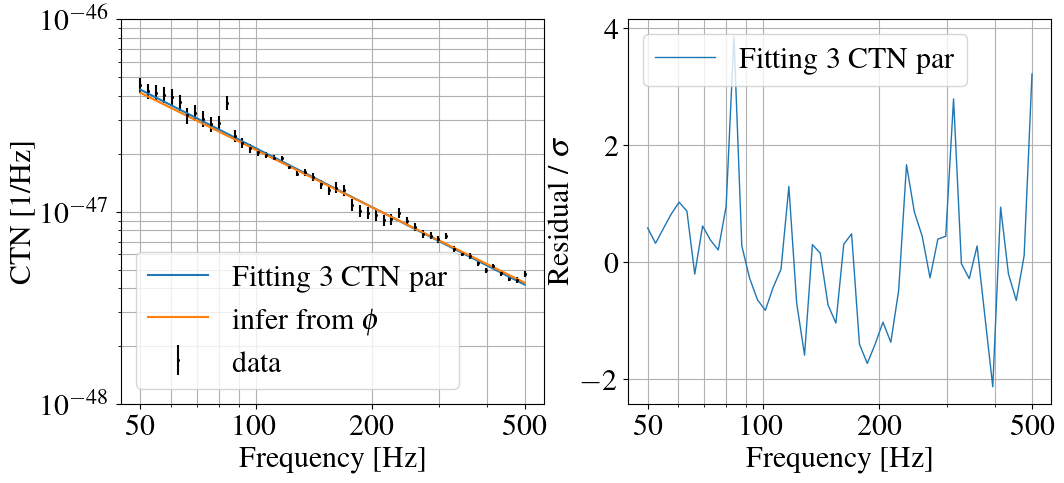

In [145]:
import lib, importlib; importlib.reload(lib)


folder1 = './fig/CTN/0514/subtractQN/model/'
# import fig.FIS.MCMC.Gaussian_prior.Parm_270kW.NoRebinDeltaG.MCMC_FIS as mcmc1
# importlib.reload(mcmc1)
key1 = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
freq1 = np.geomspace(50,500,50)
label1 = r'Fitting 3 CTN par'

unsfile = '0514_all_Unsqz_FCmis_LOonCLF'
budget = gwinc.load_budget('./L1_0514_FC7000.yaml')
trace = budget.run(freq=freq1)

result = []; result_n = []; result_p = []; likelihood = []; likelihood_l = [];
i = 0



nburn = 2000

plt.subplot(1, 2, 1)
chain = np.load(folder1+unsfile+'.npy')
[nwalkers, nsteps, ndim] = chain.shape
samples = chain[:, nburn:, :].reshape((-1, ndim))

mdl = model(np.median(samples, axis=0), freq1, budget, key1)
[data, relerr] = getdata(freq1, unsfile)
plt.errorbar(freq1, abs(data), abs(data)*[relerr, relerr], marker='*', ms=1.75, color='black',
             ls='-', lw=0, elinewidth=1.5, label='data')
plt.loglog(freq1, abs(mdl), label=label1)
plt.loglog(freq1, trace.CoatingBrownian.psd, label='infer from $\phi$')

plt.subplot(1, 2, 2)
plt.semilogx(freq1, (data-mdl)/abs(data*relerr), 'o-', ms=0, lw=1.0, label=label1)


plt.subplot(1, 2, 1)
plt.xscale('log'); plt.yscale('log')
# plt.xlim(50, 500); 
plt.ylim(1e-48, 1e-46)
# plt.xlim(2000, 3000); plt.ylim(2e-23, 3e-23)
plt.xticks([50,100,200,500], ('50','100','200','500'))
plt.xlabel('Frequency [Hz]'); 
plt.ylabel(r'CTN [1/Hz]')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.legend()
plt.grid(which='both')


plt.subplot(1, 2, 2)
# plt.semilogx(freq, data-mdl)
# plt.xscale('log'); plt.yscale('log')
# plt.xlim(50, 500); 
plt.xticks([50,100,200,500], ('50','100','200','500'))
# plt.ylabel('Residual [$\sigma$]')
plt.ylabel('Residual / $\sigma$')
# plt.ylim(-20, 20)
# plt.xlim(2000, 3000); plt.ylim(2e-23, 3e-23)
plt.xlabel('Frequency [Hz]'); 
# plt.ylabel(r'Relative residual [%]')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.legend()
plt.grid(which='both')


fig = plt.gcf()
# fig.set_size_inches(20,6)
fig.set_size_inches(12,5)
# fig.suptitle(title, y=0.95, fontsize=10)
# plt.savefig('./result.pdf')
plt.show()

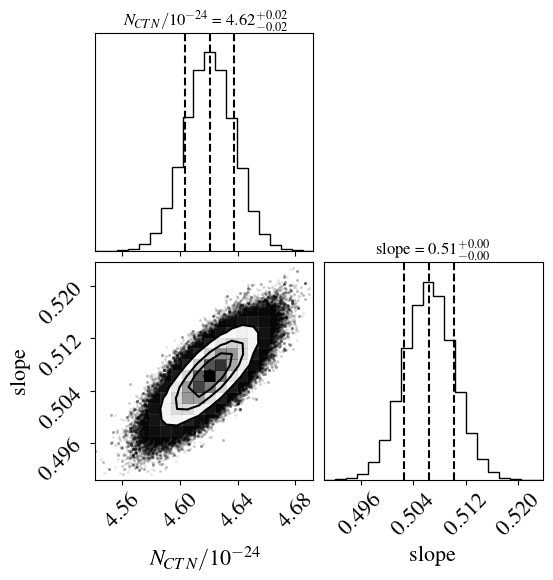

In [140]:
def convertUnit(samples, key):
    samples[:,0] = db2mag(samples[:,0])*1e24
    samples[:,1] = db2mag(samples[:,1])
    return samples


[nwalkers, nsteps, ndim] = chain.shape
samples = chain[:, nburn:, :].reshape((-1, ndim))
samples = convertUnit(samples, key1)

fig = corner.corner(samples, labels=['$N_{CTN}/10^{-24}$', 'slope'],
                   quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});
# fig.suptitle('$\phi_{low}$ = 2.3e-5', y=1.02, fontsize=14)
fig.set_size_inches((6, 6));

Now we make the plots with updated yaml file

In [175]:
modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'
unsfile = './data/0514_all_Unsqz_FCmis_LOonCLF.h5'
fdsfile = './data/0514_22_FDS.h5'


D_r = lib.DARM(unsfile); D_r.relerr_n = D_r.relerrD_n; D_r.relerr_p = D_r.relerrD_p
D_r.calcErr(); # D_r.removeLines('DARM'); 
D_r_psd = deepcopy(D_r)


# M = np.load('./fig/FIS/MCMC/all/FitmmPsiOMC/S_med.npy')
# budget = gwinc.load_budget('Aplus')
# init(budget)
budget = gwinc.load_budget('./L1_0514_FC7000.yaml')
ifo = budget.ifo
ifo.Squeezer.Type = 'None'
trace = budget.run(freq=D_r.f, ifo=ifo)
M_psd = lib.DARM()
M_psd.f = D_r.f
M_psd.S = trace.Quantum.psd

C = D_r - M_psd
C_psd = D_r - M_psd


# psd plot
freq = np.geomspace(20,2000,500)
D_r_psd.rebin_log(freq)
# D_s_psd.rebin_log(freq)
C_psd.rebin_log(freq)


# dot with errbar plot
freq = np.geomspace(50,500,50)

D_r.removeLines('DARM'); D_r.rebin_log(freq)

N = deepcopy(C)
N.relerr_n = D_r.relerrN_n
N.relerr_p = D_r.relerrN_p
N.calcErr(); N.removeLines('DARM'); N.rebin_log(freq)

# M.setZeroErr(); M.calcErr(); M.removeLines('DARM'); M.rebin_log(freq)
trace = budget.run(freq=freq, ifo=ifo);
M = lib.DARM(); M.f = freq
M.S = trace.Quantum.psd
(relerrM_n, relerrM_p) = np.load(modelerrfile)
modelf = np.geomspace(20,2000,100)
relerrM_n = np.interp(M.f, modelf, relerrM_n)
relerrM_p = np.interp(M.f, modelf, relerrM_p)
M.relerr_n = relerrM_n; M.relerr_p = relerrM_p
M.calcErr(); 

C.calcErr();
C.removeLines('DARM'); C.rebin_log(freq)

G = lib.DARM(); G.f = freq
G.err_n = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_n)
G.err_p = C.S*np.interp(freq, D_r.f_lin, D_r.relerrG_p)


C.err_n = np.sqrt( (D_r.err_n)**2 + (N.err_n)**2 + (M.err_n)**2 + (G.err_n)**2 )
C.err_p = np.sqrt( (D_r.err_p)**2 + (N.err_p)**2 + (M.err_p)**2 + (G.err_p)**2 )


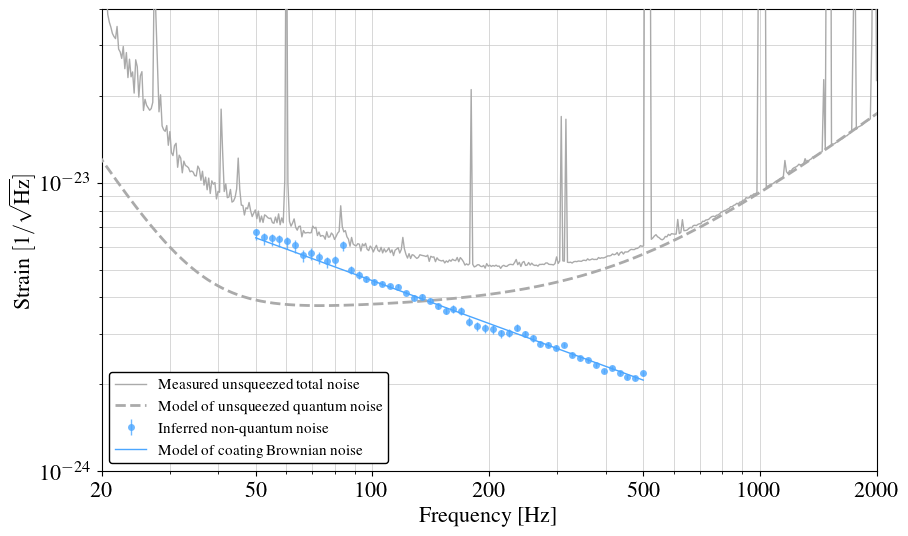

In [176]:
fontscale = 1.0
matplotlib.rc('font',**{'family':'serif','serif':['Times'], 'size':16*fontscale})

PRXcolor = np.array([173,3,222])/255
# sqzcolor = PRXcolor
sqzcolor = 'mediumorchid'
# sqlcolor = np.array([200,10,10])/255
# sqlcolor2 = np.array([242,158,142])/255
sqlcolor = 'orangered'
sqlcolor2 = 'lightsalmon'
l1color = [75/255,166/255,255/255] # From O3 instrument paper
grayrgb = 170
gray = [grayrgb/255,grayrgb/255,grayrgb/255]

fig, ax = plt.subplots()

ax.errorbar(C.f, np.sqrt(abs(C.S)), [C.err_n, C.err_p]/(2*np.sqrt(abs(C.S))), ecolor=l1color, marker='o', markerfacecolor=l1color, alpha=0.8,
             ms=5,ls='-',lw=0,c=l1color, elinewidth=1,capsize=0,mew=0,zorder=20,label='Inferred non-quantum noise')

ax.loglog(C.f, np.sqrt(trace.CoatingBrownian.psd),c=l1color, linestyle='-', lw = 1.0,label='Model of coating Brownian noise',zorder=10)


ax.loglog(D_r_psd.f, np.sqrt(D_r_psd.S), c=gray, label = 'Measured unsqueezed total noise',linewidth = 1,zorder=10)
# ax.loglog(D_s.f, np.sqrt(D_s.S),c=sqzcolor,label = 'Measured squeezed total noise',linewidth = 1,zorder=15)
ax.loglog(M_psd.f, np.sqrt(M_psd.S),c=gray, linestyle='--', lw = 2.0,label='Model of unsqueezed quantum noise',zorder=10)


# ax.loglog(C_psd.f, np.sqrt(abs(C_psd.S)), c='black', lw = 1,label='Inferred non-quantum noise', zorder = 5)


ax.set_xticks([20,50,100,200,500,1000,2000], ('20','50','100','200','500','1000','2000'))
ax.set_xlim(20, 2000); ax.set_ylim(1e-24, 4e-23)

grayrgb = 200
ax.grid(True, which='both', color=[grayrgb/255,grayrgb/255,grayrgb/255], linestyle='-', linewidth=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
legend = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], edgecolor="black", 
                   fontsize=11*fontscale, loc='best')

# legend = ax.legend(edgecolor="black", fontsize=10)
legend.set_zorder(100)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor('white')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'Strain $\mathrm{[1/\sqrt{Hz}]}$')
# ax.set_title(fdsfile)

# arrowx = np.exp((np.log(20)+np.log(30))/2)
# arrowy1 = np.sqrt(8*scipy.constants.hbar/40/(2*np.pi*arrowx)**2)/4000
# arrowy2 = np.sqrt(8*scipy.constants.hbar/40/(2*np.pi*arrowx)**2)/4000/10**(3/20)
# plt.annotate(text='', xy=(arrowx,arrowy1), xytext=(arrowx,arrowy2), arrowprops=dict(arrowstyle='<->'))


fig.set_size_inches(10, 6)

# plt.savefig('./fig/moneyplot.svg')
# plt.savefig('./fig/moneyplot.pdf')
plt.show()

In [17]:

modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'
(relerrM_n, relerrM_p) = np.load(modelerrfile)


fislist  = [26, 12, 28, 30, 10, 11, 19, 2, 4, 6, 7]

filelist = [
    ('0514_26_QND_plus70', '0514_25_Unsqz_FCmis_LOonCLF'),
    ('0514_12_QND_plus100', '0514_9_Unsqz_FCmis_LOonCLF'),
    ('0514_28_QND_plus140', '0514_27_Unsqz_FCmis_LOonCLF'),
    ('0514_30_QND_plus170', '0514_29_Unsqz_FCmis_LOonCLF'),
    ('0514_10_QND_minus30', '0514_9_Unsqz_FCmis_LOonCLF'),
    ('0514_11_QND_minus50', '0514_9_Unsqz_FCmis_LOonCLF'),
    ('0514_19_QND_plus250', '0514_17_Unsqz_FCmis_LOonCLF'),
    ('0514_2_FIS', '0514_1_Unsqz_FCmis_LOonCLF'),
    ('0514_22_FDS', '0514_all_Unsqz_FCmis_LOonCLF'),
]

sqzAngle  = [  -24.5, -12.8,    -8.5,    -5.1,    0.3,    2.6,   3.9,    14.2,   19.2,   22.9,   36.9]
mmPsi_OMC = [132.076, 0.544, -45.241, -45.498, 45.712, 30.026, -30.77, -50.473, 15.858, -13.904, -7.609]
phirms    = [ 74.099,  24.495, 19.857, 20.060, 28.546, 27.316, 25.528, 27.187, 28.549, 26.027, 24.321]


filedir = './data/';
fileext = '.h5'

QList = []
MsList = []

iList = [1,3,4,6]

# i = 0
# for file in filelist:
for i in iList:
    file = filelist[i]
    sqzfile = file[0]
    unsfile = file[1]
    
    # D_r = lib.DARM(filedir+unsfile+fileext)
    D_s = lib.DARM(filedir+sqzfile+fileext)

    budget = gwinc.load_budget('L1_0514_FC7000.yaml')
    ifo = budget.ifo
    # ifo.Squeezer.Type = 'None'
    # trace = budget.run(freq=D_r.f, ifo=ifo)
    # C = lib.DARM()
    # C.f = D_r.f
    # C.S = D_r.S - trace.Quantum.psd
    
    
    freq = np.geomspace(20,500,500)
    
    # D_r.relerr_n = D_r.relerrD_n; D_r.relerr_p = D_r.relerrD_p
    # D_r.calcErr(); # D_r.removeLines('DARM'); 
    # D_r.rebin_log(freq)

    D_s.relerr_n = D_s.relerrD_n; D_s.relerr_p = D_s.relerrD_p
    D_s.calcErr(); # D_s.removeLines('DARM'); 
    D_s.rebin_log(freq)

#     trace = budget.run(freq=D_r.f, ifo=ifo)
#     M = lib.DARM()
#     M.f = D_r.f
#     M.S = trace.Quantum.psd
#     M.err_n = M.S*np.interp(M.f, np.geomspace(20,2000,100), relerrM_n)
#     M.err_p = M.S*np.interp(M.f, np.geomspace(20,2000,100), relerrM_p)


#     Q = D_s - C
#     Q.err_n = np.sqrt((D_s.err_n)**2 + (D_r.err_n)**2 + (C.err_n)**2 + (Q.S*np.interp(Q.f, D_s.f_lin, D_s.relerrG_n))**2 + (M.err_n)**2)
#     Q.err_p = np.sqrt((D_s.err_p)**2 + (D_r.err_p)**2 + (C.err_p)**2 + (Q.S*np.interp(Q.f, D_s.f_lin, D_s.relerrG_p))**2 + (M.err_p)**2)
    QList.append(D_s)
    

    ifo.Squeezer.Type = 'Freq Independent'
    ifo.Squeezer.SQZAngle = sqzAngle[i] *np.pi/180; # 12.3 is sqz corresponding to -11 deg LO angle, 0.14 deg SRCL detuning, and -31 dB MM_SR
    ifo.Optics.MM_IFO_OMCphi = mmPsi_OMC[i] *np.pi/180
    ifo.Squeezer.SQZAngleRMS = phirms[i] *1e-3; # 28.4 [rad]
        
    
    M_s = lib.DARM(); M_s.f = freq; 
    trace = budget.run(freq=M_s.f, ifo=ifo)
    M_s.S = trace.Quantum.psd
    MsList.append(M_s)
    
    # i+=1




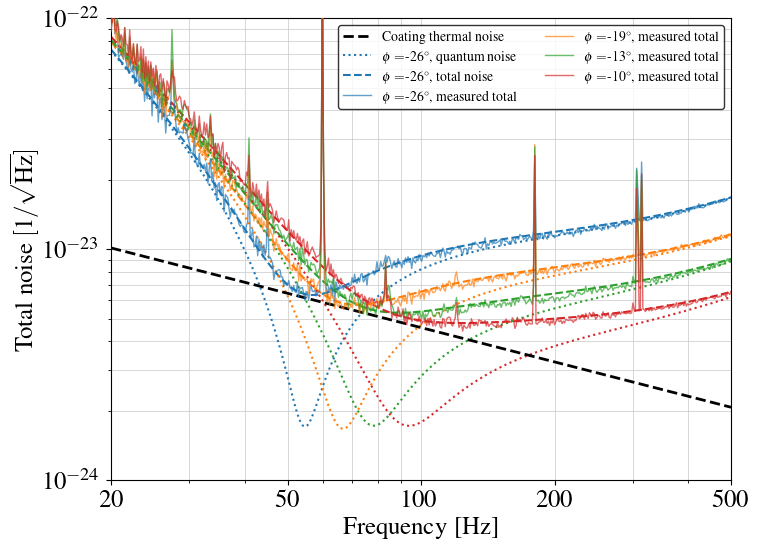

In [22]:
import inspiral_range

def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)



slide = False

c = 3e8; L_FC = 300; 
PRXcolor = np.array([173,3,222])/255
# sqzcolor = PRXcolor
sqzcolor = 'mediumorchid'
idealcolor = 'pink'
# sqlcolor = np.array([200,10,10])/255
# sqlcolor2 = np.array([242,158,142])/255
sqlcolor = 'orangered'
sqlcolor2 = 'lightsalmon'

phasesqz = 13.9

if slide:
    fontscale = 1.2
else:
    fontscale = 1.0

matplotlib.rc('font',**{'family':'serif','serif':['Times'], 'size':18*fontscale})


colors = ['teal',
         'olive',
         'lime',
         'deepskyblue']

S_CTN = trace.CoatingBrownian.psd
plt.loglog(freq, np.sqrt(S_CTN), ls='--', lw=2.0, c='black', zorder=30, label='Coating thermal noise')


for i in range(len(QList)):
    Q = QList[i]
    M_s = MsList[i]
    angle = sqzAngle[iList[i]] - phasesqz
        
    # plt.errorbar(Q.f, np.sqrt(abs(Q.S)), [Q.err_n, Q.err_p]/(2*np.sqrt(abs(Q.S))), marker='o', alpha=0.8, c=colors[i],
    #              ms=3,ls='-',lw=0, elinewidth=1,capsize=0,mew=0,zorder=10,label='$\phi = $'+str(int(1*angle))+'$^\circ$')
    

    plt.loglog(M_s.f, np.sqrt(M_s.S), linestyle='dotted', linewidth=1.5, alpha=1.0, zorder=2, label='$\phi = $'+str(int(1*angle))+'$^\circ$, quantum noise') # get last color of the plot
    clr = plt.gca().lines[-1].get_color()
    plt.loglog(M_s.f, np.sqrt(M_s.S+S_CTN), linestyle='--', linewidth=1.5, alpha=1.0, zorder=2, color=clr, label='$\phi = $'+str(int(1*angle))+'$^\circ$, total noise') # get last color of the plot
    plt.loglog(Q.f, np.sqrt(Q.S), c=clr, linewidth=1, alpha=0.7, zorder=50, label='$\phi = $'+str(int(1*angle))+'$^\circ$, measured total') 
    
    # ax.loglog(freq, np.sqrt(C.S),c=[100/255,100/255,100/255],label = 'Subtraction',linewidth = 0.7,zorder=10)
    # ax.loglog(D_r.f, np.sqrt(D_r.S),c=[0/255,0/255,0/255],label = 'D_r',linewidth = 0.7,zorder=10)
    # ax.loglog(D_s.f, np.sqrt(D_s.S),c=[140/255,75/255,20/255],label = 'D_s',linewidth = 0.7,zorder=3)
    # ax.loglog(C.f, np.sqrt(abs(C.S)),c = 'lightgray', lw = 0.7,label='C', zorder = 5)
   

    

plt.xticks([20,50,100,200,500,1000,2000], ('20','50','100','200','500','1000','2000'))
plt.xlim(20, 500); plt.ylim(1e-24, 1e-22)

grayrgb = 200
plt.grid(True, which='both', color=[grayrgb/255,grayrgb/255,grayrgb/255], linestyle='-', linewidth=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,6,9,12]

legend = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right', fontsize=10, edgecolor='black', ncol=2)
# legend = plt.legend(loc='upper right', fontsize=10, edgecolor='black', ncol=2)
legend.bbox_to_anchor=(0.5, 1.25)
# legend = ax.legend(edgecolor="black", fontsize=10)
legend.set_zorder(1000)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor('white')


plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Total noise $\mathrm{[1/\sqrt{Hz}]}$')
# ax.set_title(fdsfile)



fig = plt.gcf()
fig.set_size_inches(8, 6)
# if slide:
#     fig.set_size_inches(18, 7)
# else:
#     fig.set_size_inches(16, 7)

    
# fig.tight_layout()

if slide:
    plt.savefig('./fig/Non_QN_2.svg')
    plt.savefig('./fig/Non_QN_2.pdf')
else:
    plt.savefig('./fig/Non_QN.svg')
    plt.savefig('./fig/Non_QN.pdf')

plt.show()

# Infer Non-QN together with QN

Previously, we talked about inferring Non-QN from subtracting QN inferred from DARM difference. The other way to infer Non-QN is to assume that the total noise is analytical in certain frequency band. For example, the total noise between 50-500 Hz is mostly CTN and QN, which are analytical. Therefore, we try to fit both CTN and QN simultaneously. 

The advantage of this method is that it doesn't require coherent subtraction of noise sources, so less uncertainties propagated in the final result (one less statistical uncertainty and no need to worry about non-stationarity). 

The disadvantage is that there are two more CTN parameters to infer for MCMC, in addition to many parameters for QN. This takes even longer time for MCMC.

Actually, this method also needs to fit squeezing angles, and it doesn't remove readout-loss as DARM difference does. So I'm not sure if doing brute force MCMC with a lots of parameters (2 CTN + 4 IFO + 2 SQZ + n SQZ angle + n phase noise + n mmPsi_OMC). 

In [163]:
def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)
    
def getdata(freq, filelist):
    # print(filelist)
    direc = './data/';
    ext = '.h5'
    # modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'

    Slist = np.array([])
    relerrlist = np.array([])
    freqlist = np.array([])
    
    for file in filelist:
        fisfile = file
        # print(fisfile)
        D_s = lib.DARM(direc+fisfile+ext); D_s.relerr_n = D_s.relerrD_n; D_s.relerr_p = D_s.relerrD_p
        D_s.calcErr(); # D_s.removeLines('DARM'); 
        
        # freq = np.geomspace(50,500,50)
        D_s.removeLines('DARM'); D_s.rebin_log(freq)
        D_s.err_n = np.sqrt( (D_s.err_n)**2 + (D_s.S*np.interp(freq, D_s.f_lin, D_s.relerrG_n))**2 )
        Slist = np.concatenate((Slist, D_s.S), axis=0)
        relerrlist = np.concatenate((relerrlist, (D_s.err_n + D_s.err_p)/2/D_s.S), axis=0)
        # freqlist = np.concatenate((freqlist, np.concatenate((freq, freq), axis=0)), axis=0)

    data = Slist
    relerr = relerrlist
    return (data, relerr)
    
    
def model(param, freq, budget, key):
    ifo = budget.ifo
    ifo[key[0]] = db2mag(param[0]) # phi_highn
    ifo[key[1]] = db2mag(param[1]) # phi_highn slope
    ifo[key[2]] = db2mag(param[2]) # P_arm
    ifo[key[4]] = param[4] # gouy_SR
    ifo[key[2]] = 1 - db2mag(param[2]) # readout out loss
    ifo[key[3]] = param[3] # MM_OMC
    ifo[key[5]] = db2mag(param[5])
    ifo[key[6]] = db2mag(param[6])
    ifo[key[7]] = param[7]
    ifo[key[8]] = param[8]
    
    ifo.Squeezer.Type = 'Freq Independent'
    trace = budget.run(freq=freq, ifo=ifo)
    S_fis = trace.Quantum.psd
    S_CTN = trace.CoatingBrownian.psd
    
    return S_fis + S_CTN


def logGaussianPrior(param, bound): # bound[0] and bound[1] are +- sigma
    prior = 0
    for i in range(len(param)):
        mu = (bound[i][0]+bound[i][1])/2
        sigma = abs(bound[i][1]-mu)
        prior += np.log(1.0/(np.sqrt(2*np.pi*sigma**2)))-0.5*(param[i]-mu)**2/sigma**2
    return prior


def logLike(param, freq, budget, key, data, relerr):
    mdl = model(param, freq, budget, key)
    result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)
    # result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2)
    if np.isnan(result):
        result = -np.inf
    return result


def logPost(param, freq, budget, key, bound, data, relerr):
    result = logLike(param, freq, budget, key, data, relerr) + logGaussianPrior(param, bound)
    # if np.isnan(resut):
    #     print(logLike(param, freq, ifo, key, data))
    return result


def pltmcmcsetup(param, bound, xlabel):
    plt.hist(param, density=True, label='Initial walkers')
    mu = (bound[1]+bound[0])/2
    sigma = abs(bound[1]-bound[0])/2
    x = np.linspace(mu-2.5*sigma, mu+2.5*sigma, 100)
    plt.plot(x, 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2), '-', label='Prior')
    plt.plot([mu-sigma,mu-sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black', label='Prior $\pm 1 \sigma$')
    plt.plot([mu+sigma,mu+sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black')
    # plt.yscale(yscale)
    # ax = plt.gca()
    # ax.yaxis.set_minor_formatter('{x:.1f}')
    # ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    plt.xlabel(xlabel)
    # plt.legend()
    # plt.title(title0)

    
def convertUnit(samples, key):
    for i in range(len(key)):
        k = key[i]
        if k == 'Squeezer.SQZAngle' or k == 'Optics.SRM.SRCGouy_rad' or k == 'Optics.MM_IFO_OMCphi' or k == 'Optics.MM_ARM_SRCphi' or k == 'Squeezer.MM_SQZ_OMCphi' or k == 'Squeezer.FilterCavity.psi_mm':
            # print('Squeezer.SQZAngle')
            samples[:,i] = samples[:,i]*180/np.pi
        if k == 'Optics.SRM.Tunephase':
            samples[:,i] = db2mag(samples[:,i])*180/np.pi
        if k == 'Laser.ArmPower':
            # print('Laser.ArmPower')
            samples[:,i] = db2mag(samples[:,i])/1000
        if k == 'Optics.PhotoDetectorEfficiency' or k == 'Optics.MM_IFO_OMC' or k == 'Squeezer.FilterCavity.L_mm' or k == 'Squeezer.InjectionLoss' or k == 'Optics.MM_ARM_SRC' or k == 'Squeezer.MM_SQZ_OMC':
            # print('Optics.PhotoDetectorEfficiency')
            samples[:,i] = db2mag(samples[:,i])*100
        if k == 'Squeezer.SQZAngleRMS':
            # print('Squeezer.SQZAngleRMS')
            samples[:,i] = db2mag(samples[:,i])*1000
        if k == 'Squeezer.FilterCavity.Ti' or k == 'Squeezer.FilterCavity.Lrt' or k == 'Optics.BSLoss':
            # print('Squeezer.FilterCavity.Lrt')
            samples[:,i] = db2mag(samples[:,i])*1e6
        if k == 'Squeezer.FilterCavity.Lrms':
            samples[:,i] = db2mag(samples[:,i])*1e12
        if k == 'Materials.Coating.Phihighn' or k == 'Materials.Coating.Philown':
            samples[:,i] = db2mag(samples[:,i])*1e5
        if k == 'Materials.Coating.Phihighn_slope':
            samples[:,i] = db2mag(samples[:,i])*1e2
    return samples


def mcmc(result_queue, filelist, param0):
    # freq = np.geomspace(20,2000,100)
    freq = np.geomspace(50,500,50)
    [data, relerr] = getdata(freq, filelist)
    
    budget = gwinc.load_budget('L1_0514_FC7000.yaml')
    ifo = budget.ifo
    
    key = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
    
    bound = [
        (db(3e-24), db(5e-24)), # phi_highn
        # (db(2e-5), db(10e-5)), # phi_lown
        (db(0.45), db(0.55)), # phi_highn slope
    ]

    [nwalkers, ndim] = param0.shape
    nsteps = 10000 # number of steps each walker will take
    nthreads = 16 # number of parallel threads to use
    
    print('Start MCMC')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=(freq, budget, key, bound, data, relerr), threads=nthreads);
    sampler.run_mcmc(param0, nsteps, store=True, skip_initial_state_check=True);

    samples = sampler.chain
    # np.save(folder + 'chain_' + str(round(rand()*10000000)) + '.npy', samples.astype(np.float32))
    result_queue.put((samples, True))


def main():
    filelist = [
        # '0514_26_QND_plus70',
        '0514_12_QND_plus100',
        '0514_28_QND_plus140',
        '0514_30_QND_plus170',
        '0514_10_QND_minus30',
        '0514_11_QND_minus50',
        '0514_19_QND_plus250',
    ]

    
    folder = './'
    temp = np.linspace(1,100,100)
    np.save(folder + 'test.npy', temp.astype(np.float32))
    
    
    start = time.time()
    
    for file in filelist:
        
        budget = gwinc.load_budget('L1_0514_FC7000.yaml')
        ifo = budget.ifo

        key = [
        'Materials.Coating.Phihighn',
        # 'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
        ]

        ndim = len(key) # number of parameters to estimate
        ncores = multiprocessing.cpu_count()
        ncores = 16
        print('Total ' + str(ncores) + ' CPU cores')
        nwalkerPerCore = ndim*2
        nwalkers = ncores*nwalkerPerCore # number of walkers


        # Choose initial conditions

        # print('Max likelihood = ' + str(-np.sum(np.log(2*np.pi*abs(data*relerr)**2)/2)))
        # defaultLike = logLike(param, freq, budget, key, data, relerr)
        # print('Initial default likelihood is '+str(defaultLike))


        bound0 = [
            (db(3e-24), db(5e-24)), # phi_highn
            # (db(2e-5), db(10e-5)), # phi_lown
            (db(0.45), db(0.55)), # phi_highn slope
        ]



        # param0 = np.array(
        #     [[(bound0[i][1]+bound0[i][0])/2 + abs((bound0[i][1]-bound0[i][0])/2)*randn()
        #      for i in range(ndim)]
        #     for ii in range(nwalkers)]) 

        param0 = np.array(
            [[bound0[i][0] + (bound0[i][1]-bound0[i][0])*rand()
             for i in range(ndim)]
            for ii in range(nwalkers)]) 


        result_queue = multiprocessing.Queue()
        workers = []
        for i in range(ncores):
            worker = multiprocessing.Process(
                target=mcmc, args=(result_queue, file, param0[i*nwalkerPerCore:(i+1)*nwalkerPerCore, :])
            )
            # print('Start '+str(i))
            worker.start()
            workers.append(worker)

        finished = 0
        while True:
            try:
                chain, result = result_queue.get(timeout=0.1)
                if result:
                    finished += 1
                    print(str(finished) + " cores finished!")
                    if finished == 1:
                        chains = chain
                    else:
                        chains = np.concatenate((chains, chain), axis=0)
                    if finished == ncores:
                        break
            except KeyboardInterrupt:
                break
            except (multiprocessing.TimeoutError, queue.Empty):
                pass
        for worker in workers:
            worker.kill()

        
        np.save(folder + file + '.npy', chains.astype(np.float32))
        
    end = time.time()
    print(str((end - start)/60) + ' min')

# if __name__ == "__main__":
#     main()

# Appendix

## Appendix A: More MCMC tests

This is a MCMC that fits three parameters: phi_highn, phi_lown, and phi_highn slope. 

In [74]:
def db(num):
    return 20*np.log10(num)

def db2mag(num):
    return 10**(num/20)
  

    
def getdata(freq, filelist):
    # print(filelist)
    direc = './data/';
    ext = '.h5'
    
    modelerrfile = './fig/FIS/MCMC/all/FitmmPsiOMC/deltaM.npy'

    Slist = np.array([])
    relerrlist = np.array([])
    freqlist = np.array([])
    filelist = [filelist]
    
    for file in filelist:
        unsfile = file
        # print(unsfile)
        D_r = lib.DARM(direc+unsfile+ext); D_r.relerr_n = D_r.relerrD_n; D_r.relerr_p = D_r.relerrD_p
        D_r.calcErr(); # D_r.removeLines('DARM'); 
        
        budget = gwinc.load_budget('./L1_0514_FC7000.yaml')
        ifo = budget.ifo
        ifo.Squeezer.Type = 'None'
        trace = budget.run(freq=D_r.f, ifo=ifo)
        M_psd = lib.DARM()
        M_psd.f = D_r.f
        M_psd.S = trace.Quantum.psd

        C = D_r - M_psd

        # freq = np.geomspace(50,500,50)

        D_r.removeLines('DARM'); D_r.rebin_log(freq)

        N = deepcopy(C)
        N.relerr_n = D_r.relerrN_n
        N.relerr_p = D_r.relerrN_p
        N.calcErr(); N.removeLines('DARM'); N.rebin_log(freq)

        # M.setZeroErr(); M.calcErr(); M.removeLines('DARM'); M.rebin_log(freq)
        trace = budget.run(freq=freq, ifo=ifo);
        M = lib.DARM(); M.f = freq
        M.S = trace.Quantum.psd
        (relerrM_n, relerrM_p) = np.load(modelerrfile)
        modelf = np.geomspace(20,2000,100)
        relerrM_n = np.interp(M.f, modelf, relerrM_n)
        relerrM_p = np.interp(M.f, modelf, relerrM_p)
        M.relerr_n = relerrM_n; M.relerr_p = relerrM_p
        M.calcErr(); 

        C.calcErr();
        C.removeLines('DARM'); C.rebin_log(freq)

        G = lib.DARM(); G.f = freq
        G.err_n = C.S*np.interp(freq, D_s.f, D_s.relerrG_n)
        G.err_p = C.S*np.interp(freq, D_s.f, D_s.relerrG_p)


        C.err_n = np.sqrt( (D_r.err_n)**2 + (N.err_n)**2 + (M.err_n)**2 + (G.err_n)**2 )
        C.err_p = np.sqrt( (D_r.err_p)**2 + (N.err_p)**2 + (M.err_p)**2 + (G.err_p)**2 )

        
        Slist = np.concatenate((Slist, C.S), axis=0)
        relerrlist = np.concatenate((relerrlist, (C.err_n + C.err_p)/2/C.S), axis=0)
        # freqlist = np.concatenate((freqlist, np.concatenate((freq, freq), axis=0)), axis=0)


    data = Slist
    relerr = relerrlist
    return (data, relerr)
    
    
def model(param, freq, budget, key):
    
    ifo = budget.ifo
    ifo[key[0]] = db2mag(param[0]) # phi_highn
    ifo[key[1]] = db2mag(param[1]) # phi_lown
    ifo[key[2]] = db2mag(param[2]) # phi_highn slope

    trace = budget.run(freq=freq, ifo=ifo)
    return trace.CoatingBrownian.psd
    # return np.concatenate((S_diff, S_shot), axis=0)


# def logFlatPrior(param, bound):
#     prior = 0
#     for j in range(len(param)):
#         if param[j] < bound[j][0] or param[j] > bound[j][1]:
#             #print(str(param[j]) + " out of " + str(bound[j]))
#             prior = -np.inf
#     return prior

def logGaussianPrior(param, bound): # bound[0] and bound[1] are +- sigma
    prior = 0
    for i in range(len(param)):
        mu = (bound[i][0]+bound[i][1])/2
        sigma = abs(bound[i][1]-mu)
        prior += np.log(1.0/(np.sqrt(2*np.pi*sigma**2)))-0.5*(param[i]-mu)**2/sigma**2
    return prior


def logLike(param, freq, budget, key, data, relerr):
    mdl = model(param, freq, budget, key)
    result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)
    # result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2)
    if np.isnan(result):
        result = -np.inf
    return result


def logPost(param, freq, budget, key, bound, data, relerr):
    result = logLike(param, freq, budget, key, data, relerr) + logGaussianPrior(param, bound)
    # if np.isnan(resut):
    #     print(logLike(param, freq, ifo, key, data))
    return result


def pltmcmcsetup(param, bound, xlabel):
    plt.hist(param, density=True, label='Initial walkers')
    mu = (bound[1]+bound[0])/2
    sigma = abs(bound[1]-bound[0])/2
    x = np.linspace(mu-2.5*sigma, mu+2.5*sigma, 100)
    plt.plot(x, 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-0.5*(x-mu)**2/sigma**2), '-', label='Prior')
    plt.plot([mu-sigma,mu-sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black', label='Prior $\pm 1 \sigma$')
    plt.plot([mu+sigma,mu+sigma], [0, 1/np.sqrt(2*np.pi*sigma**2)], '--', color='black')
    # plt.yscale(yscale)
    # ax = plt.gca()
    # ax.yaxis.set_minor_formatter('{x:.1f}')
    # ax.yaxis.set_major_formatter('{x:.1f}')
    plt.grid(which='both')
    plt.xlabel(xlabel)
    # plt.legend()
    # plt.title(title0)
    
    

def mcmc(result_queue, filelist, param0):
    # freq = np.geomspace(20,2000,100)
    freq = np.geomspace(50,500,50)
    [data, relerr] = getdata(freq, filelist)
    
    budget = gwinc.load_budget('L1_0514_FC7000.yaml')
    ifo = budget.ifo
    
    key = [
        'Materials.Coating.Phihighn',
        'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
    
    bound = [
        (db(30e-5), db(90e-5)), # phi_highn
        (db(2e-5), db(10e-5)), # phi_lown
        (db(0.05), db(0.15)), # phi_highn slope
    ]

    [nwalkers, ndim] = param0.shape
    nsteps = 10000 # number of steps each walker will take
    nthreads = 16 # number of parallel threads to use
    
    print('Start MCMC')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=(freq, budget, key, bound, data, relerr), threads=nthreads);
    sampler.run_mcmc(param0, nsteps, store=True, skip_initial_state_check=True);

    samples = sampler.chain
    # np.save(folder + 'chain_' + str(round(rand()*10000000)) + '.npy', samples.astype(np.float32))
    result_queue.put((samples, True))


def main():
    filelist = [
        '0514_all_Unsqz_FCmis_LOonCLF'
    ]

    
    folder = './'
    temp = np.linspace(1,100,100)
    np.save(folder + 'test.npy', temp.astype(np.float32))
    
    
    start = time.time()
    
    for file in filelist:
        
        budget = gwinc.load_budget('L1_0514_FC7000.yaml')
        ifo = budget.ifo

        key = [
        'Materials.Coating.Phihighn',
        'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
        ]

        ndim = len(key) # number of parameters to estimate
        ncores = multiprocessing.cpu_count()
        ncores = 16
        print('Total ' + str(ncores) + ' CPU cores')
        nwalkerPerCore = ndim*2
        nwalkers = ncores*nwalkerPerCore # number of walkers


        # Choose initial conditions

        # print('Max likelihood = ' + str(-np.sum(np.log(2*np.pi*abs(data*relerr)**2)/2)))
        # defaultLike = logLike(param, freq, budget, key, data, relerr)
        # print('Initial default likelihood is '+str(defaultLike))


        bound0 = [
            (db(30e-5), db(90e-5)), # phi_highn
            (db(2e-5), db(10e-5)), # phi_lown
            (db(0.05), db(0.15)), # phi_highn slope
        ]



        # param0 = np.array(
        #     [[(bound0[i][1]+bound0[i][0])/2 + abs((bound0[i][1]-bound0[i][0])/2)*randn()
        #      for i in range(ndim)]
        #     for ii in range(nwalkers)]) 

        param0 = np.array(
            [[bound0[i][0] + (bound0[i][1]-bound0[i][0])*rand()
             for i in range(ndim)]
            for ii in range(nwalkers)]) 


        result_queue = multiprocessing.Queue()
        workers = []
        for i in range(ncores):
            worker = multiprocessing.Process(
                target=mcmc, args=(result_queue, file, param0[i*nwalkerPerCore:(i+1)*nwalkerPerCore, :])
            )
            # print('Start '+str(i))
            worker.start()
            workers.append(worker)

        finished = 0
        while True:
            try:
                chain, result = result_queue.get(timeout=0.1)
                if result:
                    finished += 1
                    print(str(finished) + " cores finished!")
                    if finished == 1:
                        chains = chain
                    else:
                        chains = np.concatenate((chains, chain), axis=0)
                    if finished == ncores:
                        break
            except KeyboardInterrupt:
                break
            except (multiprocessing.TimeoutError, queue.Empty):
                pass
        for worker in workers:
            worker.kill()

        
        np.save(folder + file + '.npy', chains.astype(np.float32))
        
    end = time.time()
    print(str((end - start)/60) + ' min')

if __name__ == "__main__":
    main()

Total 16 CPU cores
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC
Start MCMC


/local/wenxuan.jia/ipykernel_426934/4150399318.py:110: RuntimeWarning: overflow encountered in square
  result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)
/local/wenxuan.jia/ipykernel_426934/4150399318.py:110: RuntimeWarning: overflow encountered in divide
  result = -np.sum(abs(data - mdl)**2/abs(data*relerr)**2 + np.log(2*np.pi*abs(data*relerr)**2)/2)


1 cores finished!
2 cores finished!
3 cores finished!
4 cores finished!
5 cores finished!
6 cores finished!
7 cores finished!
8 cores finished!
9 cores finished!
10 cores finished!
11 cores finished!
12 cores finished!
13 cores finished!
14 cores finished!
15 cores finished!
16 cores finished!
122.88038579622905 min


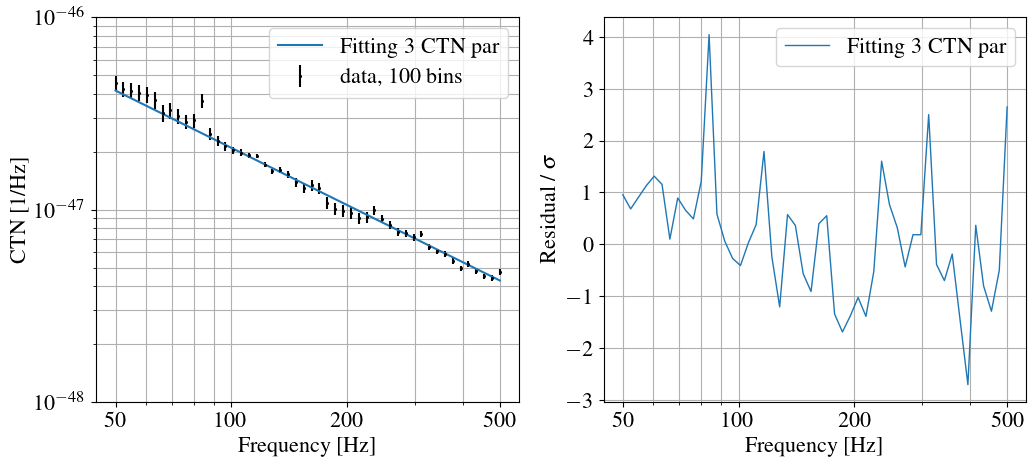

In [92]:
import lib, importlib; importlib.reload(lib)


folder1 = './'
# import fig.FIS.MCMC.Gaussian_prior.Parm_270kW.NoRebinDeltaG.MCMC_FIS as mcmc1
# importlib.reload(mcmc1)
key1 = [
        'Materials.Coating.Phihighn',
        'Materials.Coating.Philown',
        'Materials.Coating.Phihighn_slope',
    ]
freq1 = np.geomspace(50,500,50)
label1 = r'Fitting 3 CTN par'

unsfile = '0514_all_Unsqz_FCmis_LOonCLF'
budget = gwinc.load_budget('./L1_0514_FC7000.yaml')

result = []; result_n = []; result_p = []; likelihood = []; likelihood_l = [];
i = 0



nburn = 2000

plt.subplot(1, 2, 1)
chain = np.load(folder1+unsfile+'.npy')
[nwalkers, nsteps, ndim] = chain.shape
samples = chain[:, nburn:, :].reshape((-1, ndim))

mdl = model(np.median(samples, axis=0), freq1, budget, key1)
[data, relerr] = getdata(freq1, unsfile)
plt.errorbar(freq1, abs(data), abs(data)*[relerr, relerr], marker='*', ms=1.75, color='black',
             ls='-', lw=0, elinewidth=1.5, label='data, 100 bins')
plt.loglog(freq1, abs(mdl), label=label1)
plt.subplot(1, 2, 2)
plt.semilogx(freq1, (data-mdl)/abs(data*relerr), 'o-', ms=0, lw=1.0, label=label1)



plt.subplot(1, 2, 1)
plt.xscale('log'); plt.yscale('log')
# plt.xlim(50, 500); 
plt.ylim(1e-48, 1e-46)
# plt.xlim(2000, 3000); plt.ylim(2e-23, 3e-23)
plt.xticks([50,100,200,500], ('50','100','200','500'))
plt.xlabel('Frequency [Hz]'); 
plt.ylabel(r'CTN [1/Hz]')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.legend()
plt.grid(which='both')


plt.subplot(1, 2, 2)
# plt.semilogx(freq, data-mdl)
# plt.xscale('log'); plt.yscale('log')
# plt.xlim(50, 500); 
plt.xticks([50,100,200,500], ('50','100','200','500'))
# plt.ylabel('Residual [$\sigma$]')
plt.ylabel('Residual / $\sigma$')
# plt.ylim(-20, 20)
# plt.xlim(2000, 3000); plt.ylim(2e-23, 3e-23)
plt.xlabel('Frequency [Hz]'); 
# plt.ylabel(r'Relative residual [%]')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.legend()
plt.grid(which='both')


fig = plt.gcf()
# fig.set_size_inches(20,6)
fig.set_size_inches(12,5)
# fig.suptitle(title, y=0.95, fontsize=10)
# plt.savefig('./result.pdf')
plt.show()

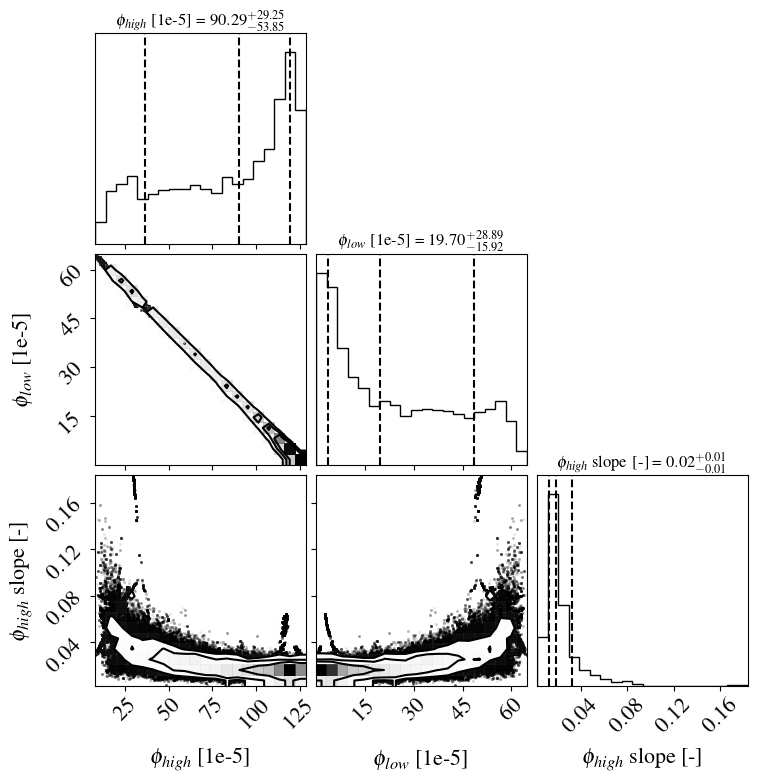

In [107]:
def convertUnit(samples, key):
    for i in range(len(key)):
        k = key[i]
        if k == 'Squeezer.SQZAngle' or k == 'Optics.SRM.SRCGouy_rad' or k == 'Optics.MM_IFO_OMCphi' or k == 'Optics.MM_ARM_SRCphi' or k == 'Squeezer.MM_SQZ_OMCphi' or k == 'Squeezer.FilterCavity.psi_mm':
            # print('Squeezer.SQZAngle')
            samples[:,i] = samples[:,i]*180/np.pi
        if k == 'Optics.SRM.Tunephase':
            samples[:,i] = db2mag(samples[:,i])*180/np.pi
        if k == 'Laser.ArmPower':
            # print('Laser.ArmPower')
            samples[:,i] = db2mag(samples[:,i])/1000
        if k == 'Optics.PhotoDetectorEfficiency' or k == 'Optics.MM_IFO_OMC' or k == 'Squeezer.FilterCavity.L_mm' or k == 'Squeezer.InjectionLoss' or k == 'Optics.MM_ARM_SRC' or k == 'Squeezer.MM_SQZ_OMC':
            # print('Optics.PhotoDetectorEfficiency')
            samples[:,i] = db2mag(samples[:,i])*100
        if k == 'Squeezer.SQZAngleRMS':
            # print('Squeezer.SQZAngleRMS')
            samples[:,i] = db2mag(samples[:,i])*1000
        if k == 'Squeezer.FilterCavity.Ti' or k == 'Squeezer.FilterCavity.Lrt' or k == 'Optics.BSLoss':
            # print('Squeezer.FilterCavity.Lrt')
            samples[:,i] = db2mag(samples[:,i])*1e6
        if k == 'Squeezer.FilterCavity.Lrms':
            samples[:,i] = db2mag(samples[:,i])*1e12
        if k == 'Materials.Coating.Phihighn' or k == 'Materials.Coating.Philown':
            samples[:,i] = db2mag(samples[:,i])*1e5
        if k == 'Materials.Coating.Phihighn_slope':
            samples[:,i] = db2mag(samples[:,i])
    return samples


[nwalkers, nsteps, ndim] = chain.shape
samples = chain[:, nburn:, :].reshape((-1, ndim))
samples = convertUnit(samples, key1)

fig = corner.corner(samples, labels=['$\phi_{high}$ [1e-5]', '$\phi_{low}$ [1e-5]', '$\phi_{high}$ slope [-]'],
                   quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12});
fig.set_size_inches((8, 8));